In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os


import copy
import warnings
warnings.filterwarnings('ignore')

import cv2
import keras
from keras.preprocessing.image import ImageDataGenerator
import matplotlib
import matplotlib.pylab as plt
import numpy as np
import seaborn as sns
import shap
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

from keras.applications.vgg16 import VGG16,preprocess_input


In [4]:
from tensorflow.keras.utils import load_img
from tensorflow.keras.utils import img_to_array

In [5]:
os.listdir('Alzheimer_s Dataset/train')
os.listdir('Alzheimer_s Dataset/test')

['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']

In [6]:
W = 128 # The default size for ResNet is 224 but resize to .5 to save memory size
H = 128 # The default size for ResNet is 224 but resize to .5 to save memory size

label_to_class = {
    'MildDemented': 0,
    'ModerateDemented': 1,
    'NonDemented': 2,
    'VeryMildDemented':3
    

}
class_to_label = {v: k for k, v in label_to_class.items()}
n_classes = len(label_to_class)

def get_images(data_type='/train', dir_name='Alzheimer_s Dataset', label_to_class=label_to_class,): #'/train','/test'
    """read images / labels from directory"""
    
    Images = []
    Classes = []
    
    for j in [data_type]: #'/train' was removed for testing purposes
        for label_name in os.listdir(dir_name+str(j)):
            cls = label_to_class[label_name]

            for img_name in os.listdir('/'.join([dir_name+str(j), label_name])):
                img = load_img('/'.join([dir_name+str(j), label_name, img_name]), target_size=(W, H))
                #img = img_to_array(img)
                img = np.array(img)

                Images.append(img)
                Classes.append(cls)
            
    Images = np.array(Images) #Don't convert data type to float32
    Classes = np.array(Classes)
    Images, Classes = shuffle(Images, Classes, random_state=0)
    
    return Images, Classes

In [7]:
trainX, trainy = get_images(data_type='/train')

trainy = trainy.reshape(-1, 1)

trainX.shape, trainy.shape

((5121, 128, 128, 3), (5121, 1))

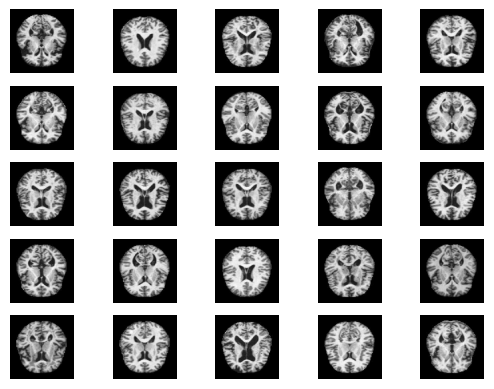

In [8]:
for i in range(25):
	plt.subplot(5, 5, 1 + i)
	plt.axis('off')
	plt.imshow(trainX[i])
plt.show()

In [9]:
from numpy import zeros
from numpy import ones
from numpy.random import randn
from numpy.random import randint
from keras.datasets.cifar10 import load_data
from keras.optimizers import Adam
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout
from keras.layers import Embedding
from keras.layers import Concatenate

from matplotlib import pyplot as plt

In [10]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [12]:
def define_discriminator(in_shape=(128,128,3), n_classes=4):
	
    # label input
	in_label = Input(shape=(1,))  #Shape 1
	# embedding for categorical input
    #each label (total 10 classes for cifar), will be represented by a vector of size 50. 
    #This vector of size 50 will be learnt by the discriminator
	li = Embedding(n_classes, 50)(in_label) #Shape 1,50
	# scale up to image dimensions with linear activation
	n_nodes = in_shape[0] * in_shape[1]  #32x32 = 1024. 
	li = Dense(n_nodes)(li)  #Shape = 1, 1024
	# reshape to additional channel
	li = Reshape((in_shape[0], in_shape[1], 1))(li)  #32x32x1
    
    
	# image input
	in_image = Input(shape=in_shape) #32x32x3
	# concat label as a channel
	merge = Concatenate()([in_image, li]) #32x32x4 (4 channels, 3 for image and the other for labels)
    
	# downsample: This part is same as unconditional GAN upto the output layer.
    #We will combine input label with input image and supply as inputs to the model. 
	fe = Conv2D(128, (3,3), strides=(2,2), padding='same')(merge) #16x16x128
	fe = LeakyReLU(alpha=0.2)(fe)
	# downsample
	fe = Conv2D(128, (3,3), strides=(2,2), padding='same')(fe) #8x8x128
	fe = LeakyReLU(alpha=0.2)(fe)
	# flatten feature maps
	fe = Flatten()(fe)  #8192  (8*8*128=8192)
	# dropout
	fe = Dropout(0.4)(fe)
	# output
	out_layer = Dense(1, activation='sigmoid')(fe)  #Shape=1
    
	# define model
    ##Combine input label with input image and supply as inputs to the model. 
	model = Model([in_image, in_label], out_layer)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
	return model

In [13]:
test_discr = define_discriminator()
print(test_discr.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 embedding (Embedding)          (None, 1, 50)        200         ['input_1[0][0]']                
                                                                                                  
 dense (Dense)                  (None, 1, 16384)     835584      ['embedding[0][0]']              
                                                                                                  
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                            

In [14]:
def define_generator(latent_dim, n_classes=4):
    
	# label input
	in_label = Input(shape=(1,))  #Input of dimension 1
	# embedding for categorical input
    #each label (total 10 classes for cifar), will be represented by a vector of size 50. 
	li = Embedding(n_classes, 50)(in_label) #Shape 1,50
    
	# linear multiplication
	n_nodes = 8 * 8  # To match the dimensions for concatenation later in this step.  
	li = Dense(n_nodes)(li) #1,64
	# reshape to additional channel
	li = Reshape((8, 8, 1))(li)
    
    
	# image generator input
	in_lat = Input(shape=(latent_dim,))  #Input of dimension 100
    
	# foundation for 8x8 image
    # We will reshape input latent vector into 8x8 image as a starting point. 
    #So n_nodes for the Dense layer can be 128x8x8 so when we reshape the output 
    #it would be 8x8x128 and that can be slowly upscaled to 32x32 image for output.
    #Note that this part is same as unconditional GAN until the output layer. 
    #While defining model inputs we will combine input label and the latent input.
	n_nodes = 128 * 8 * 8
	gen = Dense(n_nodes)(in_lat)  #shape=8192
	gen = LeakyReLU(alpha=0.2)(gen)
	gen = Reshape((8, 8, 128))(gen) #Shape=8x8x128
	# merge image gen and label input
	merge = Concatenate()([gen, li])  #Shape=8x8x129 (Extra channel corresponds to the label)
	# upsample to 16x16
	gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(merge) #16x16x128
	gen = LeakyReLU(alpha=0.2)(gen)
	# upsample to 32x32
	gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(gen) #32x32x128
	gen = LeakyReLU(alpha=0.2)(gen)
    #64x64
	gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(gen) #32x32x128
	gen = LeakyReLU(alpha=0.2)(gen)
    #128x128
	gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(gen) #32x32x128
	gen = LeakyReLU(alpha=0.2)(gen)
	# output
	out_layer = Conv2D(3, (8,8), activation='tanh', padding='same')(gen) #32x32x3
	# define model
	model = Model([in_lat, in_label], out_layer)
	return model 

In [15]:
test_gen = define_generator(100, n_classes=10)
print(test_gen.summary())

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 dense_3 (Dense)                (None, 8192)         827392      ['input_4[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, 1, 50)        500         ['input_3[0][0]']                
                                                                                            

In [16]:
def define_gan(g_model, d_model):
	d_model.trainable = False  #Discriminator is trained separately. So set to not trainable.
    
    ## connect generator and discriminator...
	# first, get noise and label inputs from generator model
	gen_noise, gen_label = g_model.input  #Latent vector size and label size
	# get image output from the generator model
	gen_output = g_model.output  #32x32x3
    
	# generator image output and corresponding input label are inputs to discriminator
	gan_output = d_model([gen_output, gen_label])
	# define gan model as taking noise and label and outputting a classification
	model = Model([gen_noise, gen_label], gan_output)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model

In [17]:
def load_real_samples():
	# load dataset
	#(trainX, trainy), (_, _) = load_data()   #cifar
	trainX, trainy = get_images(data_type='/train')
	# convert to floats and scale
	X = trainX.astype('float32')
	# scale from [0,255] to [-1,1]
	X = (X - 127.5) / 127.5   #Generator uses tanh activation so rescale 
                            #original images to -1 to 1 to match the output of generator.
	return [X, trainy]

In [18]:
def generate_real_samples(dataset, n_samples):
	# split into images and labels
	images, labels = dataset  
	# choose random instances
	ix = randint(0, images.shape[0], n_samples)
	# select images and labels
	X, labels = images[ix], labels[ix]
	# generate class labels and assign to y (don't confuse this with the above labels that correspond to cifar labels)
	y = ones((n_samples, 1))  #Label=1 indicating they are real
	return [X, labels], y

In [19]:
def generate_latent_points(latent_dim, n_samples, n_classes=4):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	z_input = x_input.reshape(n_samples, latent_dim)
	# generate labels
	labels = randint(0, n_classes, n_samples)
	return [z_input, labels]

In [20]:
def generate_fake_samples(generator, latent_dim, n_samples):
	# generate points in latent space
	z_input, labels_input = generate_latent_points(latent_dim, n_samples)
	# predict outputs
	images = generator.predict([z_input, labels_input])
	# create class labels
	y = zeros((n_samples, 1))  #Label=0 indicating they are fake
	return [images, labels_input], y

In [21]:
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=200, n_batch=128):
	bat_per_epo = int(dataset[0].shape[0] / n_batch)
	half_batch = int(n_batch / 2)  #the discriminator model is updated for a half batch of real samples 
                            #and a half batch of fake samples, combined a single batch. 
	# manually enumerate epochs
	for i in range(n_epochs):
		# enumerate batches over the training set
		for j in range(bat_per_epo):
			
             # Train the discriminator on real and fake images, separately (half batch each)
        #Research showed that separate training is more effective. 
			# get randomly selected 'real' samples
            # get randomly selected 'real' samples
			[X_real, labels_real], y_real = generate_real_samples(dataset, half_batch)

            # update discriminator model weights
            ##train_on_batch allows you to update weights based on a collection 
            #of samples you provide
			d_loss_real, _ = d_model.train_on_batch([X_real, labels_real], y_real)
            
			# generate 'fake' examples
			[X_fake, labels], y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
			# update discriminator model weights
			d_loss_fake, _ = d_model.train_on_batch([X_fake, labels], y_fake)
            
            #d_loss = 0.5 * np.add(d_loss_real, d_loss_fake) #Average loss if you want to report single..
            
			# prepare points in latent space as input for the generator
			[z_input, labels_input] = generate_latent_points(latent_dim, n_batch)
            
            # The generator wants the discriminator to label the generated samples
        # as valid (ones)
        #This is where the generator is trying to trick discriminator into believing
        #the generated image is true (hence value of 1 for y)	
			# create inverted labels for the fake samples
			y_gan = ones((n_batch, 1))
             # Generator is part of combined model where it got directly linked with the discriminator
        # Train the generator with latent_dim as x and 1 as y. 
        # Again, 1 as the output as it is adversarial and if generator did a great
        #job of folling the discriminator then the output would be 1 (true)
			# update the generator via the discriminator's error
			g_loss = gan_model.train_on_batch([z_input, labels_input], y_gan)
			# Print losses on this batch
			print('Epoch>%d, Batch%d/%d, d1=%.3f, d2=%.3f g=%.3f' %
				(i+1, j+1, bat_per_epo, d_loss_real, d_loss_fake, g_loss))
	# save the generator model
	g_model.save('model1_128x128_epoch_200.h5')

In [22]:
#Train the GAN

# size of the latent space
latent_dim = 100
# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# load image data
dataset = load_real_samples()
# train model
train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=200)

2/2 [==============================] - 1s 5ms/step
Epoch>1, Batch1/40, d1=0.642, d2=0.696 g=0.692
2/2 [==============================] - 0s 49ms/step
Epoch>1, Batch2/40, d1=0.086, d2=0.697 g=0.693
2/2 [==============================] - 0s 49ms/step
Epoch>1, Batch3/40, d1=0.023, d2=0.698 g=0.696
2/2 [==============================] - 0s 49ms/step
Epoch>1, Batch4/40, d1=0.010, d2=0.695 g=0.705
2/2 [==============================] - 0s 49ms/step
Epoch>1, Batch5/40, d1=0.006, d2=0.683 g=0.730
2/2 [==============================] - 0s 54ms/step
Epoch>1, Batch6/40, d1=0.005, d2=0.656 g=0.767
2/2 [==============================] - 0s 49ms/step
Epoch>1, Batch7/40, d1=0.005, d2=0.638 g=0.788
2/2 [==============================] - 0s 50ms/step
Epoch>1, Batch8/40, d1=0.004, d2=0.630 g=0.796
2/2 [==============================] - 0s 54ms/step
Epoch>1, Batch9/40, d1=0.004, d2=0.627 g=0.807
2/2 [==============================] - 0s 49ms/step
Epoch>1, Batch10/40, d1=0.005, d2=0.631 g=0.817
2/2 [=====

2/2 [==============================] - 0s 49ms/step
Epoch>3, Batch3/40, d1=0.141, d2=0.147 g=3.754
2/2 [==============================] - 0s 48ms/step
Epoch>3, Batch4/40, d1=0.247, d2=0.241 g=3.333
2/2 [==============================] - 0s 49ms/step
Epoch>3, Batch5/40, d1=0.160, d2=0.121 g=3.605
2/2 [==============================] - 0s 50ms/step
Epoch>3, Batch6/40, d1=0.166, d2=0.178 g=3.570
2/2 [==============================] - 0s 48ms/step
Epoch>3, Batch7/40, d1=0.285, d2=0.292 g=3.647
2/2 [==============================] - 0s 49ms/step
Epoch>3, Batch8/40, d1=0.329, d2=0.277 g=3.510
2/2 [==============================] - 0s 49ms/step
Epoch>3, Batch9/40, d1=0.232, d2=0.200 g=3.281
2/2 [==============================] - 0s 49ms/step
Epoch>3, Batch10/40, d1=0.239, d2=0.255 g=3.328
2/2 [==============================] - 0s 49ms/step
Epoch>3, Batch11/40, d1=0.187, d2=0.206 g=3.378
2/2 [==============================] - 0s 50ms/step
Epoch>3, Batch12/40, d1=0.305, d2=0.302 g=2.952
2/2 [==

2/2 [==============================] - 0s 49ms/step
Epoch>5, Batch5/40, d1=0.278, d2=0.509 g=4.507
2/2 [==============================] - 0s 49ms/step
Epoch>5, Batch6/40, d1=0.594, d2=0.269 g=3.085
2/2 [==============================] - 0s 50ms/step
Epoch>5, Batch7/40, d1=0.186, d2=0.317 g=3.939
2/2 [==============================] - 0s 49ms/step
Epoch>5, Batch8/40, d1=0.531, d2=0.433 g=3.571
2/2 [==============================] - 0s 50ms/step
Epoch>5, Batch9/40, d1=0.312, d2=0.377 g=3.531
2/2 [==============================] - 0s 49ms/step
Epoch>5, Batch10/40, d1=0.503, d2=0.581 g=3.653
2/2 [==============================] - 0s 49ms/step
Epoch>5, Batch11/40, d1=0.585, d2=0.523 g=3.733
2/2 [==============================] - 0s 49ms/step
Epoch>5, Batch12/40, d1=0.729, d2=0.844 g=4.098
2/2 [==============================] - 0s 49ms/step
Epoch>5, Batch13/40, d1=0.584, d2=0.327 g=3.275
2/2 [==============================] - 0s 49ms/step
Epoch>5, Batch14/40, d1=0.388, d2=0.517 g=4.202
2/2 [

2/2 [==============================] - 0s 49ms/step
Epoch>7, Batch7/40, d1=0.353, d2=0.468 g=3.267
2/2 [==============================] - 0s 50ms/step
Epoch>7, Batch8/40, d1=0.406, d2=0.311 g=3.132
2/2 [==============================] - 0s 49ms/step
Epoch>7, Batch9/40, d1=0.313, d2=0.378 g=3.002
2/2 [==============================] - 0s 49ms/step
Epoch>7, Batch10/40, d1=0.304, d2=0.249 g=3.084
2/2 [==============================] - 0s 49ms/step
Epoch>7, Batch11/40, d1=0.306, d2=0.305 g=3.161
2/2 [==============================] - 0s 49ms/step
Epoch>7, Batch12/40, d1=0.336, d2=0.325 g=3.372
2/2 [==============================] - 0s 48ms/step
Epoch>7, Batch13/40, d1=0.274, d2=0.265 g=3.136
2/2 [==============================] - 0s 49ms/step
Epoch>7, Batch14/40, d1=0.343, d2=0.394 g=3.510
2/2 [==============================] - 0s 49ms/step
Epoch>7, Batch15/40, d1=0.288, d2=0.191 g=3.475
2/2 [==============================] - 0s 48ms/step
Epoch>7, Batch16/40, d1=0.235, d2=0.217 g=3.540
2/2

2/2 [==============================] - 0s 48ms/step
Epoch>9, Batch9/40, d1=0.712, d2=0.308 g=3.758
2/2 [==============================] - 0s 50ms/step
Epoch>9, Batch10/40, d1=0.329, d2=0.184 g=4.283
2/2 [==============================] - 0s 49ms/step
Epoch>9, Batch11/40, d1=0.237, d2=0.106 g=4.103
2/2 [==============================] - 0s 49ms/step
Epoch>9, Batch12/40, d1=0.166, d2=0.088 g=3.604
2/2 [==============================] - 0s 49ms/step
Epoch>9, Batch13/40, d1=0.168, d2=0.178 g=3.672
2/2 [==============================] - 0s 49ms/step
Epoch>9, Batch14/40, d1=0.155, d2=0.096 g=3.769
2/2 [==============================] - 0s 49ms/step
Epoch>9, Batch15/40, d1=0.136, d2=0.148 g=3.251
2/2 [==============================] - 0s 49ms/step
Epoch>9, Batch16/40, d1=0.141, d2=0.142 g=3.306
2/2 [==============================] - 0s 49ms/step
Epoch>9, Batch17/40, d1=0.210, d2=0.231 g=3.588
2/2 [==============================] - 0s 49ms/step
Epoch>9, Batch18/40, d1=0.155, d2=0.155 g=3.664
2

2/2 [==============================] - 0s 50ms/step
Epoch>11, Batch11/40, d1=0.253, d2=0.272 g=2.565
2/2 [==============================] - 0s 49ms/step
Epoch>11, Batch12/40, d1=0.307, d2=0.332 g=2.727
2/2 [==============================] - 0s 48ms/step
Epoch>11, Batch13/40, d1=0.217, d2=0.205 g=2.931
2/2 [==============================] - 0s 49ms/step
Epoch>11, Batch14/40, d1=0.292, d2=0.221 g=3.011
2/2 [==============================] - 0s 49ms/step
Epoch>11, Batch15/40, d1=0.147, d2=0.186 g=3.363
2/2 [==============================] - 0s 48ms/step
Epoch>11, Batch16/40, d1=0.232, d2=0.103 g=3.336
2/2 [==============================] - 0s 50ms/step
Epoch>11, Batch17/40, d1=0.156, d2=0.229 g=2.770
2/2 [==============================] - 0s 50ms/step
Epoch>11, Batch18/40, d1=0.139, d2=0.163 g=3.287
2/2 [==============================] - 0s 49ms/step
Epoch>11, Batch19/40, d1=0.210, d2=0.145 g=2.944
2/2 [==============================] - 0s 48ms/step
Epoch>11, Batch20/40, d1=0.202, d2=0.27

2/2 [==============================] - 0s 50ms/step
Epoch>13, Batch12/40, d1=0.266, d2=0.376 g=2.899
2/2 [==============================] - 0s 49ms/step
Epoch>13, Batch13/40, d1=0.253, d2=0.234 g=3.642
2/2 [==============================] - 0s 49ms/step
Epoch>13, Batch14/40, d1=0.406, d2=0.246 g=3.236
2/2 [==============================] - 0s 49ms/step
Epoch>13, Batch15/40, d1=0.254, d2=0.176 g=3.031
2/2 [==============================] - 0s 49ms/step
Epoch>13, Batch16/40, d1=0.121, d2=0.157 g=3.304
2/2 [==============================] - 0s 49ms/step
Epoch>13, Batch17/40, d1=0.248, d2=0.168 g=2.958
2/2 [==============================] - 0s 48ms/step
Epoch>13, Batch18/40, d1=0.154, d2=0.238 g=3.236
2/2 [==============================] - 0s 50ms/step
Epoch>13, Batch19/40, d1=0.290, d2=0.228 g=2.860
2/2 [==============================] - 0s 49ms/step
Epoch>13, Batch20/40, d1=0.198, d2=0.283 g=2.764
2/2 [==============================] - 0s 48ms/step
Epoch>13, Batch21/40, d1=0.282, d2=0.29

2/2 [==============================] - 0s 49ms/step
Epoch>15, Batch13/40, d1=0.364, d2=0.511 g=3.130
2/2 [==============================] - 0s 49ms/step
Epoch>15, Batch14/40, d1=0.349, d2=0.189 g=2.665
2/2 [==============================] - 0s 49ms/step
Epoch>15, Batch15/40, d1=0.319, d2=0.417 g=2.894
2/2 [==============================] - 0s 49ms/step
Epoch>15, Batch16/40, d1=0.356, d2=0.283 g=2.518
2/2 [==============================] - 0s 50ms/step
Epoch>15, Batch17/40, d1=0.339, d2=0.367 g=2.822
2/2 [==============================] - 0s 49ms/step
Epoch>15, Batch18/40, d1=0.271, d2=0.352 g=2.866
2/2 [==============================] - 0s 48ms/step
Epoch>15, Batch19/40, d1=0.333, d2=0.314 g=3.081
2/2 [==============================] - 0s 49ms/step
Epoch>15, Batch20/40, d1=0.406, d2=0.312 g=2.414
2/2 [==============================] - 0s 50ms/step
Epoch>15, Batch21/40, d1=0.301, d2=0.433 g=2.592
2/2 [==============================] - 0s 48ms/step
Epoch>15, Batch22/40, d1=0.427, d2=0.36

2/2 [==============================] - 0s 50ms/step
Epoch>17, Batch14/40, d1=0.278, d2=0.304 g=2.625
2/2 [==============================] - 0s 49ms/step
Epoch>17, Batch15/40, d1=0.321, d2=0.427 g=2.754
2/2 [==============================] - 0s 48ms/step
Epoch>17, Batch16/40, d1=0.457, d2=0.389 g=2.541
2/2 [==============================] - 0s 49ms/step
Epoch>17, Batch17/40, d1=0.425, d2=0.497 g=2.535
2/2 [==============================] - 0s 49ms/step
Epoch>17, Batch18/40, d1=0.409, d2=0.370 g=2.626
2/2 [==============================] - 0s 49ms/step
Epoch>17, Batch19/40, d1=0.398, d2=0.364 g=2.609
2/2 [==============================] - 0s 49ms/step
Epoch>17, Batch20/40, d1=0.321, d2=0.331 g=2.714
2/2 [==============================] - 0s 50ms/step
Epoch>17, Batch21/40, d1=0.365, d2=0.371 g=2.500
2/2 [==============================] - 0s 49ms/step
Epoch>17, Batch22/40, d1=0.467, d2=0.481 g=2.252
2/2 [==============================] - 0s 49ms/step
Epoch>17, Batch23/40, d1=0.329, d2=0.31

2/2 [==============================] - 0s 48ms/step
Epoch>19, Batch15/40, d1=0.368, d2=0.371 g=2.652
2/2 [==============================] - 0s 50ms/step
Epoch>19, Batch16/40, d1=0.348, d2=0.400 g=2.468
2/2 [==============================] - 0s 49ms/step
Epoch>19, Batch17/40, d1=0.389, d2=0.346 g=2.359
2/2 [==============================] - 0s 49ms/step
Epoch>19, Batch18/40, d1=0.383, d2=0.484 g=2.321
2/2 [==============================] - 0s 49ms/step
Epoch>19, Batch19/40, d1=0.375, d2=0.351 g=2.184
2/2 [==============================] - 0s 49ms/step
Epoch>19, Batch20/40, d1=0.332, d2=0.532 g=2.429
2/2 [==============================] - 0s 49ms/step
Epoch>19, Batch21/40, d1=0.531, d2=0.345 g=2.247
2/2 [==============================] - 0s 49ms/step
Epoch>19, Batch22/40, d1=0.340, d2=0.654 g=2.355
2/2 [==============================] - 0s 50ms/step
Epoch>19, Batch23/40, d1=0.607, d2=0.521 g=2.504
2/2 [==============================] - 0s 48ms/step
Epoch>19, Batch24/40, d1=0.478, d2=0.52

2/2 [==============================] - 0s 49ms/step
Epoch>21, Batch16/40, d1=0.440, d2=0.614 g=1.862
2/2 [==============================] - 0s 49ms/step
Epoch>21, Batch17/40, d1=0.545, d2=0.468 g=2.384
2/2 [==============================] - 0s 49ms/step
Epoch>21, Batch18/40, d1=0.611, d2=0.524 g=1.830
2/2 [==============================] - 0s 49ms/step
Epoch>21, Batch19/40, d1=0.437, d2=0.452 g=2.096
2/2 [==============================] - 0s 48ms/step
Epoch>21, Batch20/40, d1=0.424, d2=0.503 g=1.796
2/2 [==============================] - 0s 49ms/step
Epoch>21, Batch21/40, d1=0.402, d2=0.554 g=2.616
2/2 [==============================] - 0s 49ms/step
Epoch>21, Batch22/40, d1=0.528, d2=0.414 g=2.194
2/2 [==============================] - 0s 50ms/step
Epoch>21, Batch23/40, d1=0.462, d2=0.414 g=2.556
2/2 [==============================] - 0s 50ms/step
Epoch>21, Batch24/40, d1=0.390, d2=0.501 g=2.166
2/2 [==============================] - 0s 50ms/step
Epoch>21, Batch25/40, d1=0.427, d2=0.43

2/2 [==============================] - 0s 49ms/step
Epoch>23, Batch17/40, d1=0.539, d2=0.475 g=1.623
2/2 [==============================] - 0s 48ms/step
Epoch>23, Batch18/40, d1=0.391, d2=0.642 g=2.011
2/2 [==============================] - 0s 49ms/step
Epoch>23, Batch19/40, d1=0.503, d2=0.421 g=1.957
2/2 [==============================] - 0s 50ms/step
Epoch>23, Batch20/40, d1=0.528, d2=0.472 g=1.941
2/2 [==============================] - 0s 49ms/step
Epoch>23, Batch21/40, d1=0.377, d2=0.428 g=1.979
2/2 [==============================] - 0s 48ms/step
Epoch>23, Batch22/40, d1=0.543, d2=0.487 g=1.724
2/2 [==============================] - 0s 49ms/step
Epoch>23, Batch23/40, d1=0.431, d2=0.503 g=1.892
2/2 [==============================] - 0s 48ms/step
Epoch>23, Batch24/40, d1=0.420, d2=0.469 g=2.207
2/2 [==============================] - 0s 49ms/step
Epoch>23, Batch25/40, d1=0.571, d2=0.583 g=1.872
2/2 [==============================] - 0s 49ms/step
Epoch>23, Batch26/40, d1=0.498, d2=0.50

2/2 [==============================] - 0s 51ms/step
Epoch>25, Batch18/40, d1=0.533, d2=0.717 g=2.299
2/2 [==============================] - 0s 49ms/step
Epoch>25, Batch19/40, d1=0.525, d2=0.486 g=2.387
2/2 [==============================] - 0s 50ms/step
Epoch>25, Batch20/40, d1=0.608, d2=0.585 g=1.866
2/2 [==============================] - 0s 49ms/step
Epoch>25, Batch21/40, d1=0.486, d2=0.509 g=2.510
2/2 [==============================] - 0s 50ms/step
Epoch>25, Batch22/40, d1=0.481, d2=0.410 g=2.202
2/2 [==============================] - 0s 50ms/step
Epoch>25, Batch23/40, d1=0.427, d2=0.717 g=1.996
2/2 [==============================] - 0s 50ms/step
Epoch>25, Batch24/40, d1=0.547, d2=0.344 g=2.734
2/2 [==============================] - 0s 49ms/step
Epoch>25, Batch25/40, d1=0.525, d2=0.585 g=1.742
2/2 [==============================] - 0s 49ms/step
Epoch>25, Batch26/40, d1=0.414, d2=0.451 g=2.320
2/2 [==============================] - 0s 49ms/step
Epoch>25, Batch27/40, d1=0.368, d2=0.28

2/2 [==============================] - 0s 50ms/step
Epoch>27, Batch19/40, d1=0.438, d2=0.580 g=1.800
2/2 [==============================] - 0s 50ms/step
Epoch>27, Batch20/40, d1=0.665, d2=0.585 g=1.656
2/2 [==============================] - 0s 48ms/step
Epoch>27, Batch21/40, d1=0.456, d2=0.660 g=2.120
2/2 [==============================] - 0s 49ms/step
Epoch>27, Batch22/40, d1=0.659, d2=0.575 g=1.837
2/2 [==============================] - 0s 49ms/step
Epoch>27, Batch23/40, d1=0.586, d2=0.553 g=2.126
2/2 [==============================] - 0s 49ms/step
Epoch>27, Batch24/40, d1=0.540, d2=0.693 g=1.814
2/2 [==============================] - 0s 50ms/step
Epoch>27, Batch25/40, d1=0.576, d2=0.539 g=1.828
2/2 [==============================] - 0s 49ms/step
Epoch>27, Batch26/40, d1=0.530, d2=0.601 g=2.001
2/2 [==============================] - 0s 49ms/step
Epoch>27, Batch27/40, d1=0.561, d2=0.517 g=1.939
2/2 [==============================] - 0s 47ms/step
Epoch>27, Batch28/40, d1=0.560, d2=0.47

2/2 [==============================] - 0s 50ms/step
Epoch>29, Batch20/40, d1=0.471, d2=0.438 g=1.893
2/2 [==============================] - 0s 49ms/step
Epoch>29, Batch21/40, d1=0.478, d2=0.515 g=1.823
2/2 [==============================] - 0s 49ms/step
Epoch>29, Batch22/40, d1=0.475, d2=0.563 g=1.931
2/2 [==============================] - 0s 49ms/step
Epoch>29, Batch23/40, d1=0.504, d2=0.524 g=1.897
2/2 [==============================] - 0s 49ms/step
Epoch>29, Batch24/40, d1=0.471, d2=0.623 g=1.778
2/2 [==============================] - 0s 49ms/step
Epoch>29, Batch25/40, d1=0.447, d2=0.497 g=1.840
2/2 [==============================] - 0s 49ms/step
Epoch>29, Batch26/40, d1=0.608, d2=0.595 g=1.669
2/2 [==============================] - 0s 48ms/step
Epoch>29, Batch27/40, d1=0.525, d2=0.568 g=1.831
2/2 [==============================] - 0s 49ms/step
Epoch>29, Batch28/40, d1=0.496, d2=0.678 g=1.838
2/2 [==============================] - 0s 49ms/step
Epoch>29, Batch29/40, d1=0.545, d2=0.52

2/2 [==============================] - 0s 49ms/step
Epoch>31, Batch21/40, d1=0.414, d2=0.574 g=1.773
2/2 [==============================] - 0s 49ms/step
Epoch>31, Batch22/40, d1=0.512, d2=0.523 g=1.943
2/2 [==============================] - 0s 50ms/step
Epoch>31, Batch23/40, d1=0.565, d2=0.526 g=1.733
2/2 [==============================] - 0s 50ms/step
Epoch>31, Batch24/40, d1=0.455, d2=0.492 g=1.706
2/2 [==============================] - 0s 48ms/step
Epoch>31, Batch25/40, d1=0.541, d2=0.467 g=1.596
2/2 [==============================] - 0s 48ms/step
Epoch>31, Batch26/40, d1=0.424, d2=0.559 g=1.760
2/2 [==============================] - 0s 49ms/step
Epoch>31, Batch27/40, d1=0.485, d2=0.557 g=1.664
2/2 [==============================] - 0s 49ms/step
Epoch>31, Batch28/40, d1=0.469, d2=0.542 g=1.814
2/2 [==============================] - 0s 49ms/step
Epoch>31, Batch29/40, d1=0.559, d2=0.511 g=1.762
2/2 [==============================] - 0s 49ms/step
Epoch>31, Batch30/40, d1=0.524, d2=0.57

2/2 [==============================] - 0s 48ms/step
Epoch>33, Batch22/40, d1=0.491, d2=0.515 g=2.012
2/2 [==============================] - 0s 49ms/step
Epoch>33, Batch23/40, d1=0.485, d2=0.483 g=1.792
2/2 [==============================] - 0s 55ms/step
Epoch>33, Batch24/40, d1=0.494, d2=0.472 g=1.631
2/2 [==============================] - 0s 50ms/step
Epoch>33, Batch25/40, d1=0.417, d2=0.587 g=1.963
2/2 [==============================] - 0s 49ms/step
Epoch>33, Batch26/40, d1=0.461, d2=0.513 g=1.716
2/2 [==============================] - 0s 50ms/step
Epoch>33, Batch27/40, d1=0.601, d2=0.546 g=1.913
2/2 [==============================] - 0s 49ms/step
Epoch>33, Batch28/40, d1=0.536, d2=0.523 g=1.979
2/2 [==============================] - 0s 49ms/step
Epoch>33, Batch29/40, d1=0.529, d2=0.526 g=1.648
2/2 [==============================] - 0s 48ms/step
Epoch>33, Batch30/40, d1=0.466, d2=0.541 g=1.621
2/2 [==============================] - 0s 48ms/step
Epoch>33, Batch31/40, d1=0.535, d2=0.51

2/2 [==============================] - 0s 48ms/step
Epoch>35, Batch23/40, d1=0.425, d2=0.547 g=1.731
2/2 [==============================] - 0s 48ms/step
Epoch>35, Batch24/40, d1=0.481, d2=0.492 g=1.870
2/2 [==============================] - 0s 49ms/step
Epoch>35, Batch25/40, d1=0.507, d2=0.454 g=1.778
2/2 [==============================] - 0s 48ms/step
Epoch>35, Batch26/40, d1=0.418, d2=0.439 g=1.975
2/2 [==============================] - 0s 50ms/step
Epoch>35, Batch27/40, d1=0.388, d2=0.538 g=1.788
2/2 [==============================] - 0s 48ms/step
Epoch>35, Batch28/40, d1=0.409, d2=0.494 g=2.215
2/2 [==============================] - 0s 50ms/step
Epoch>35, Batch29/40, d1=0.482, d2=0.439 g=2.019
2/2 [==============================] - 0s 49ms/step
Epoch>35, Batch30/40, d1=0.506, d2=0.391 g=2.260
2/2 [==============================] - 0s 49ms/step
Epoch>35, Batch31/40, d1=0.416, d2=0.623 g=1.799
2/2 [==============================] - 0s 49ms/step
Epoch>35, Batch32/40, d1=0.486, d2=0.51

2/2 [==============================] - 0s 49ms/step
Epoch>37, Batch24/40, d1=0.462, d2=0.466 g=1.808
2/2 [==============================] - 0s 50ms/step
Epoch>37, Batch25/40, d1=0.425, d2=0.484 g=1.504
2/2 [==============================] - 0s 50ms/step
Epoch>37, Batch26/40, d1=0.466, d2=0.596 g=2.023
2/2 [==============================] - 0s 49ms/step
Epoch>37, Batch27/40, d1=0.510, d2=0.522 g=2.231
2/2 [==============================] - 0s 49ms/step
Epoch>37, Batch28/40, d1=0.527, d2=0.527 g=2.007
2/2 [==============================] - 0s 48ms/step
Epoch>37, Batch29/40, d1=0.554, d2=0.488 g=1.895
2/2 [==============================] - 0s 48ms/step
Epoch>37, Batch30/40, d1=0.466, d2=0.535 g=2.236
2/2 [==============================] - 0s 50ms/step
Epoch>37, Batch31/40, d1=0.613, d2=0.472 g=1.832
2/2 [==============================] - 0s 49ms/step
Epoch>37, Batch32/40, d1=0.430, d2=0.538 g=1.959
2/2 [==============================] - 0s 48ms/step
Epoch>37, Batch33/40, d1=0.450, d2=0.48

2/2 [==============================] - 0s 49ms/step
Epoch>39, Batch25/40, d1=0.526, d2=0.340 g=2.290
2/2 [==============================] - 0s 49ms/step
Epoch>39, Batch26/40, d1=0.516, d2=0.627 g=1.850
2/2 [==============================] - 0s 48ms/step
Epoch>39, Batch27/40, d1=0.495, d2=0.441 g=2.110
2/2 [==============================] - 0s 49ms/step
Epoch>39, Batch28/40, d1=0.375, d2=0.625 g=2.048
2/2 [==============================] - 0s 48ms/step
Epoch>39, Batch29/40, d1=0.628, d2=0.539 g=2.370
2/2 [==============================] - 0s 50ms/step
Epoch>39, Batch30/40, d1=0.474, d2=0.528 g=1.595
2/2 [==============================] - 0s 49ms/step
Epoch>39, Batch31/40, d1=0.529, d2=0.375 g=2.084
2/2 [==============================] - 0s 50ms/step
Epoch>39, Batch32/40, d1=0.424, d2=0.498 g=1.846
2/2 [==============================] - 0s 50ms/step
Epoch>39, Batch33/40, d1=0.354, d2=0.756 g=2.218
2/2 [==============================] - 0s 49ms/step
Epoch>39, Batch34/40, d1=0.526, d2=0.33

2/2 [==============================] - 0s 49ms/step
Epoch>41, Batch26/40, d1=0.434, d2=0.531 g=2.137
2/2 [==============================] - 0s 49ms/step
Epoch>41, Batch27/40, d1=0.467, d2=0.439 g=2.017
2/2 [==============================] - 0s 48ms/step
Epoch>41, Batch28/40, d1=0.409, d2=0.419 g=2.231
2/2 [==============================] - 0s 54ms/step
Epoch>41, Batch29/40, d1=0.481, d2=0.431 g=2.101
2/2 [==============================] - 0s 56ms/step
Epoch>41, Batch30/40, d1=0.527, d2=0.459 g=1.835
2/2 [==============================] - 0s 57ms/step
Epoch>41, Batch31/40, d1=0.397, d2=0.555 g=1.924
2/2 [==============================] - 0s 49ms/step
Epoch>41, Batch32/40, d1=0.417, d2=0.443 g=1.995
2/2 [==============================] - 0s 50ms/step
Epoch>41, Batch33/40, d1=0.517, d2=0.426 g=1.864
2/2 [==============================] - 0s 49ms/step
Epoch>41, Batch34/40, d1=0.468, d2=0.480 g=1.812
2/2 [==============================] - 0s 50ms/step
Epoch>41, Batch35/40, d1=0.376, d2=0.46

2/2 [==============================] - 0s 49ms/step
Epoch>43, Batch27/40, d1=0.486, d2=0.484 g=1.727
2/2 [==============================] - 0s 49ms/step
Epoch>43, Batch28/40, d1=0.468, d2=0.486 g=2.053
2/2 [==============================] - 0s 49ms/step
Epoch>43, Batch29/40, d1=0.497, d2=0.428 g=1.526
2/2 [==============================] - 0s 49ms/step
Epoch>43, Batch30/40, d1=0.462, d2=0.541 g=1.655
2/2 [==============================] - 0s 49ms/step
Epoch>43, Batch31/40, d1=0.427, d2=0.463 g=1.887
2/2 [==============================] - 0s 49ms/step
Epoch>43, Batch32/40, d1=0.434, d2=0.506 g=1.964
2/2 [==============================] - 0s 49ms/step
Epoch>43, Batch33/40, d1=0.471, d2=0.560 g=1.911
2/2 [==============================] - 0s 49ms/step
Epoch>43, Batch34/40, d1=0.485, d2=0.349 g=1.891
2/2 [==============================] - 0s 49ms/step
Epoch>43, Batch35/40, d1=0.457, d2=0.582 g=2.022
2/2 [==============================] - 0s 50ms/step
Epoch>43, Batch36/40, d1=0.497, d2=0.46

2/2 [==============================] - 0s 50ms/step
Epoch>45, Batch28/40, d1=0.443, d2=0.437 g=1.928
2/2 [==============================] - 0s 49ms/step
Epoch>45, Batch29/40, d1=0.400, d2=0.547 g=2.127
2/2 [==============================] - 0s 49ms/step
Epoch>45, Batch30/40, d1=0.451, d2=0.397 g=1.930
2/2 [==============================] - 0s 50ms/step
Epoch>45, Batch31/40, d1=0.475, d2=0.477 g=1.768
2/2 [==============================] - 0s 49ms/step
Epoch>45, Batch32/40, d1=0.448, d2=0.554 g=1.610
2/2 [==============================] - 0s 49ms/step
Epoch>45, Batch33/40, d1=0.483, d2=0.582 g=1.955
2/2 [==============================] - 0s 50ms/step
Epoch>45, Batch34/40, d1=0.521, d2=0.462 g=1.816
2/2 [==============================] - 0s 51ms/step
Epoch>45, Batch35/40, d1=0.502, d2=0.406 g=1.692
2/2 [==============================] - 0s 50ms/step
Epoch>45, Batch36/40, d1=0.398, d2=0.603 g=1.741
2/2 [==============================] - 0s 49ms/step
Epoch>45, Batch37/40, d1=0.519, d2=0.46

2/2 [==============================] - 0s 49ms/step
Epoch>47, Batch29/40, d1=0.551, d2=0.568 g=2.000
2/2 [==============================] - 0s 49ms/step
Epoch>47, Batch30/40, d1=0.420, d2=0.416 g=1.907
2/2 [==============================] - 0s 52ms/step
Epoch>47, Batch31/40, d1=0.447, d2=0.361 g=1.995
2/2 [==============================] - 0s 49ms/step
Epoch>47, Batch32/40, d1=0.417, d2=0.499 g=1.889
2/2 [==============================] - 0s 49ms/step
Epoch>47, Batch33/40, d1=0.456, d2=0.444 g=2.071
2/2 [==============================] - 0s 49ms/step
Epoch>47, Batch34/40, d1=0.400, d2=0.562 g=2.128
2/2 [==============================] - 0s 49ms/step
Epoch>47, Batch35/40, d1=0.533, d2=0.411 g=2.024
2/2 [==============================] - 0s 49ms/step
Epoch>47, Batch36/40, d1=0.474, d2=0.464 g=1.833
2/2 [==============================] - 0s 49ms/step
Epoch>47, Batch37/40, d1=0.456, d2=0.472 g=1.829
2/2 [==============================] - 0s 50ms/step
Epoch>47, Batch38/40, d1=0.371, d2=0.55

2/2 [==============================] - 0s 50ms/step
Epoch>49, Batch30/40, d1=0.392, d2=0.450 g=2.075
2/2 [==============================] - 0s 50ms/step
Epoch>49, Batch31/40, d1=0.441, d2=0.430 g=1.914
2/2 [==============================] - 0s 50ms/step
Epoch>49, Batch32/40, d1=0.419, d2=0.432 g=1.879
2/2 [==============================] - 0s 49ms/step
Epoch>49, Batch33/40, d1=0.410, d2=0.452 g=2.002
2/2 [==============================] - 0s 49ms/step
Epoch>49, Batch34/40, d1=0.438, d2=0.478 g=2.018
2/2 [==============================] - 0s 50ms/step
Epoch>49, Batch35/40, d1=0.440, d2=0.480 g=2.057
2/2 [==============================] - 0s 50ms/step
Epoch>49, Batch36/40, d1=0.474, d2=0.387 g=1.862
2/2 [==============================] - 0s 49ms/step
Epoch>49, Batch37/40, d1=0.437, d2=0.433 g=1.957
2/2 [==============================] - 0s 49ms/step
Epoch>49, Batch38/40, d1=0.380, d2=0.499 g=2.025
2/2 [==============================] - 0s 50ms/step
Epoch>49, Batch39/40, d1=0.392, d2=0.35

2/2 [==============================] - 0s 50ms/step
Epoch>51, Batch31/40, d1=0.450, d2=0.462 g=1.932
2/2 [==============================] - 0s 48ms/step
Epoch>51, Batch32/40, d1=0.477, d2=0.438 g=2.128
2/2 [==============================] - 0s 48ms/step
Epoch>51, Batch33/40, d1=0.446, d2=0.470 g=2.065
2/2 [==============================] - 0s 50ms/step
Epoch>51, Batch34/40, d1=0.387, d2=0.479 g=1.978
2/2 [==============================] - 0s 50ms/step
Epoch>51, Batch35/40, d1=0.494, d2=0.468 g=2.208
2/2 [==============================] - 0s 48ms/step
Epoch>51, Batch36/40, d1=0.428, d2=0.320 g=2.178
2/2 [==============================] - 0s 50ms/step
Epoch>51, Batch37/40, d1=0.431, d2=0.422 g=1.928
2/2 [==============================] - 0s 50ms/step
Epoch>51, Batch38/40, d1=0.385, d2=0.475 g=2.009
2/2 [==============================] - 0s 49ms/step
Epoch>51, Batch39/40, d1=0.333, d2=0.451 g=2.161
2/2 [==============================] - 0s 49ms/step
Epoch>51, Batch40/40, d1=0.492, d2=0.41

2/2 [==============================] - 0s 50ms/step
Epoch>53, Batch32/40, d1=0.449, d2=0.332 g=2.083
2/2 [==============================] - 0s 48ms/step
Epoch>53, Batch33/40, d1=0.448, d2=0.403 g=2.033
2/2 [==============================] - 0s 50ms/step
Epoch>53, Batch34/40, d1=0.434, d2=0.436 g=1.540
2/2 [==============================] - 0s 49ms/step
Epoch>53, Batch35/40, d1=0.330, d2=0.570 g=2.056
2/2 [==============================] - 0s 49ms/step
Epoch>53, Batch36/40, d1=0.422, d2=0.417 g=1.902
2/2 [==============================] - 0s 49ms/step
Epoch>53, Batch37/40, d1=0.468, d2=0.509 g=2.116
2/2 [==============================] - 0s 49ms/step
Epoch>53, Batch38/40, d1=0.379, d2=0.457 g=2.199
2/2 [==============================] - 0s 49ms/step
Epoch>53, Batch39/40, d1=0.534, d2=0.382 g=1.834
2/2 [==============================] - 0s 48ms/step
Epoch>53, Batch40/40, d1=0.492, d2=0.626 g=2.021
2/2 [==============================] - 0s 50ms/step
Epoch>54, Batch1/40, d1=0.396, d2=0.359

2/2 [==============================] - 0s 50ms/step
Epoch>55, Batch33/40, d1=0.348, d2=0.503 g=2.529
2/2 [==============================] - 0s 50ms/step
Epoch>55, Batch34/40, d1=0.485, d2=0.364 g=2.271
2/2 [==============================] - 0s 50ms/step
Epoch>55, Batch35/40, d1=0.385, d2=0.375 g=1.759
2/2 [==============================] - 0s 49ms/step
Epoch>55, Batch36/40, d1=0.347, d2=0.404 g=2.269
2/2 [==============================] - 0s 49ms/step
Epoch>55, Batch37/40, d1=0.366, d2=0.421 g=2.256
2/2 [==============================] - 0s 49ms/step
Epoch>55, Batch38/40, d1=0.399, d2=0.508 g=2.180
2/2 [==============================] - 0s 48ms/step
Epoch>55, Batch39/40, d1=0.387, d2=0.303 g=2.379
2/2 [==============================] - 0s 49ms/step
Epoch>55, Batch40/40, d1=0.420, d2=0.514 g=1.992
2/2 [==============================] - 0s 50ms/step
Epoch>56, Batch1/40, d1=0.384, d2=0.341 g=2.688
2/2 [==============================] - 0s 48ms/step
Epoch>56, Batch2/40, d1=0.429, d2=0.481 

2/2 [==============================] - 0s 49ms/step
Epoch>57, Batch34/40, d1=0.451, d2=0.475 g=1.987
2/2 [==============================] - 0s 50ms/step
Epoch>57, Batch35/40, d1=0.355, d2=0.368 g=1.927
2/2 [==============================] - 0s 49ms/step
Epoch>57, Batch36/40, d1=0.447, d2=0.546 g=2.034
2/2 [==============================] - 0s 50ms/step
Epoch>57, Batch37/40, d1=0.485, d2=0.490 g=2.141
2/2 [==============================] - 0s 50ms/step
Epoch>57, Batch38/40, d1=0.444, d2=0.431 g=2.080
2/2 [==============================] - 0s 49ms/step
Epoch>57, Batch39/40, d1=0.434, d2=0.495 g=2.321
2/2 [==============================] - 0s 49ms/step
Epoch>57, Batch40/40, d1=0.488, d2=0.357 g=1.801
2/2 [==============================] - 0s 49ms/step
Epoch>58, Batch1/40, d1=0.384, d2=0.456 g=2.020
2/2 [==============================] - 0s 49ms/step
Epoch>58, Batch2/40, d1=0.351, d2=0.439 g=2.168
2/2 [==============================] - 0s 49ms/step
Epoch>58, Batch3/40, d1=0.512, d2=0.388 g

2/2 [==============================] - 0s 49ms/step
Epoch>59, Batch35/40, d1=0.378, d2=0.471 g=2.082
2/2 [==============================] - 0s 50ms/step
Epoch>59, Batch36/40, d1=0.375, d2=0.539 g=2.123
2/2 [==============================] - 0s 49ms/step
Epoch>59, Batch37/40, d1=0.425, d2=0.380 g=2.238
2/2 [==============================] - 0s 51ms/step
Epoch>59, Batch38/40, d1=0.490, d2=0.414 g=2.149
2/2 [==============================] - 0s 49ms/step
Epoch>59, Batch39/40, d1=0.466, d2=0.419 g=2.171
2/2 [==============================] - 0s 49ms/step
Epoch>59, Batch40/40, d1=0.330, d2=0.460 g=2.187
2/2 [==============================] - 0s 49ms/step
Epoch>60, Batch1/40, d1=0.444, d2=0.434 g=2.141
2/2 [==============================] - 0s 49ms/step
Epoch>60, Batch2/40, d1=0.338, d2=0.374 g=1.901
2/2 [==============================] - 0s 49ms/step
Epoch>60, Batch3/40, d1=0.440, d2=0.393 g=2.112
2/2 [==============================] - 0s 49ms/step
Epoch>60, Batch4/40, d1=0.404, d2=0.418 g=

2/2 [==============================] - 0s 48ms/step
Epoch>61, Batch36/40, d1=0.449, d2=0.510 g=1.809
2/2 [==============================] - 0s 50ms/step
Epoch>61, Batch37/40, d1=0.328, d2=0.498 g=2.400
2/2 [==============================] - 0s 50ms/step
Epoch>61, Batch38/40, d1=0.424, d2=0.413 g=2.475
2/2 [==============================] - 0s 48ms/step
Epoch>61, Batch39/40, d1=0.535, d2=0.466 g=2.097
2/2 [==============================] - 0s 50ms/step
Epoch>61, Batch40/40, d1=0.400, d2=0.449 g=2.011
2/2 [==============================] - 0s 49ms/step
Epoch>62, Batch1/40, d1=0.424, d2=0.489 g=2.334
2/2 [==============================] - 0s 49ms/step
Epoch>62, Batch2/40, d1=0.516, d2=0.512 g=1.922
2/2 [==============================] - 0s 50ms/step
Epoch>62, Batch3/40, d1=0.448, d2=0.464 g=2.250
2/2 [==============================] - 0s 49ms/step
Epoch>62, Batch4/40, d1=0.468, d2=0.442 g=2.226
2/2 [==============================] - 0s 50ms/step
Epoch>62, Batch5/40, d1=0.372, d2=0.378 g=2

2/2 [==============================] - 0s 49ms/step
Epoch>63, Batch37/40, d1=0.410, d2=0.441 g=2.408
2/2 [==============================] - 0s 48ms/step
Epoch>63, Batch38/40, d1=0.499, d2=0.473 g=2.025
2/2 [==============================] - 0s 50ms/step
Epoch>63, Batch39/40, d1=0.410, d2=0.398 g=1.788
2/2 [==============================] - 0s 49ms/step
Epoch>63, Batch40/40, d1=0.366, d2=0.443 g=2.034
2/2 [==============================] - 0s 48ms/step
Epoch>64, Batch1/40, d1=0.397, d2=0.347 g=2.001
2/2 [==============================] - 0s 49ms/step
Epoch>64, Batch2/40, d1=0.455, d2=0.414 g=1.893
2/2 [==============================] - 0s 50ms/step
Epoch>64, Batch3/40, d1=0.379, d2=0.356 g=2.128
2/2 [==============================] - 0s 49ms/step
Epoch>64, Batch4/40, d1=0.326, d2=0.405 g=2.201
2/2 [==============================] - 0s 49ms/step
Epoch>64, Batch5/40, d1=0.384, d2=0.345 g=2.247
2/2 [==============================] - 0s 49ms/step
Epoch>64, Batch6/40, d1=0.390, d2=0.355 g=2.

2/2 [==============================] - 0s 50ms/step
Epoch>65, Batch38/40, d1=0.372, d2=0.411 g=1.884
2/2 [==============================] - 0s 50ms/step
Epoch>65, Batch39/40, d1=0.331, d2=0.446 g=2.246
2/2 [==============================] - 0s 50ms/step
Epoch>65, Batch40/40, d1=0.437, d2=0.407 g=2.148
2/2 [==============================] - 0s 49ms/step
Epoch>66, Batch1/40, d1=0.437, d2=0.444 g=2.099
2/2 [==============================] - 0s 50ms/step
Epoch>66, Batch2/40, d1=0.434, d2=0.468 g=1.982
2/2 [==============================] - 0s 49ms/step
Epoch>66, Batch3/40, d1=0.315, d2=0.540 g=2.319
2/2 [==============================] - 0s 49ms/step
Epoch>66, Batch4/40, d1=0.462, d2=0.318 g=2.266
2/2 [==============================] - 0s 50ms/step
Epoch>66, Batch5/40, d1=0.425, d2=0.385 g=2.035
2/2 [==============================] - 0s 50ms/step
Epoch>66, Batch6/40, d1=0.444, d2=0.445 g=2.404
2/2 [==============================] - 0s 48ms/step
Epoch>66, Batch7/40, d1=0.380, d2=0.504 g=2.1

2/2 [==============================] - 0s 49ms/step
Epoch>67, Batch39/40, d1=0.487, d2=0.808 g=2.215
2/2 [==============================] - 0s 49ms/step
Epoch>67, Batch40/40, d1=0.687, d2=0.700 g=2.148
2/2 [==============================] - 0s 48ms/step
Epoch>68, Batch1/40, d1=0.740, d2=0.725 g=1.916
2/2 [==============================] - 0s 49ms/step
Epoch>68, Batch2/40, d1=0.575, d2=0.805 g=2.240
2/2 [==============================] - 0s 49ms/step
Epoch>68, Batch3/40, d1=0.662, d2=0.777 g=2.015
2/2 [==============================] - 0s 48ms/step
Epoch>68, Batch4/40, d1=0.578, d2=0.648 g=2.404
2/2 [==============================] - 0s 48ms/step
Epoch>68, Batch5/40, d1=0.613, d2=0.449 g=2.216
2/2 [==============================] - 0s 49ms/step
Epoch>68, Batch6/40, d1=0.490, d2=0.604 g=2.452
2/2 [==============================] - 0s 49ms/step
Epoch>68, Batch7/40, d1=0.462, d2=0.493 g=2.271
2/2 [==============================] - 0s 49ms/step
Epoch>68, Batch8/40, d1=0.466, d2=0.667 g=2.31

2/2 [==============================] - 0s 49ms/step
Epoch>69, Batch40/40, d1=0.617, d2=0.530 g=2.022
2/2 [==============================] - 0s 50ms/step
Epoch>70, Batch1/40, d1=0.399, d2=0.548 g=2.042
2/2 [==============================] - 0s 48ms/step
Epoch>70, Batch2/40, d1=0.417, d2=0.408 g=2.046
2/2 [==============================] - 0s 49ms/step
Epoch>70, Batch3/40, d1=0.499, d2=0.526 g=1.870
2/2 [==============================] - 0s 50ms/step
Epoch>70, Batch4/40, d1=0.517, d2=0.558 g=1.988
2/2 [==============================] - 0s 49ms/step
Epoch>70, Batch5/40, d1=0.556, d2=0.548 g=1.911
2/2 [==============================] - 0s 50ms/step
Epoch>70, Batch6/40, d1=0.524, d2=0.512 g=2.087
2/2 [==============================] - 0s 48ms/step
Epoch>70, Batch7/40, d1=0.479, d2=0.394 g=1.889
2/2 [==============================] - 0s 50ms/step
Epoch>70, Batch8/40, d1=0.398, d2=0.484 g=1.852
2/2 [==============================] - 0s 51ms/step
Epoch>70, Batch9/40, d1=0.397, d2=0.542 g=1.966

2/2 [==============================] - 0s 48ms/step
Epoch>72, Batch1/40, d1=0.505, d2=0.542 g=1.920
2/2 [==============================] - 0s 50ms/step
Epoch>72, Batch2/40, d1=0.427, d2=0.451 g=2.191
2/2 [==============================] - 0s 49ms/step
Epoch>72, Batch3/40, d1=0.450, d2=0.442 g=2.200
2/2 [==============================] - 0s 48ms/step
Epoch>72, Batch4/40, d1=0.418, d2=0.431 g=2.042
2/2 [==============================] - 0s 50ms/step
Epoch>72, Batch5/40, d1=0.536, d2=0.512 g=1.858
2/2 [==============================] - 0s 50ms/step
Epoch>72, Batch6/40, d1=0.436, d2=0.457 g=2.024
2/2 [==============================] - 0s 50ms/step
Epoch>72, Batch7/40, d1=0.539, d2=0.496 g=1.829
2/2 [==============================] - 0s 50ms/step
Epoch>72, Batch8/40, d1=0.434, d2=0.454 g=1.866
2/2 [==============================] - 0s 50ms/step
Epoch>72, Batch9/40, d1=0.432, d2=0.497 g=2.271
2/2 [==============================] - 0s 49ms/step
Epoch>72, Batch10/40, d1=0.442, d2=0.496 g=2.005

2/2 [==============================] - 0s 50ms/step
Epoch>74, Batch2/40, d1=0.461, d2=0.495 g=1.954
2/2 [==============================] - 0s 50ms/step
Epoch>74, Batch3/40, d1=0.492, d2=0.427 g=1.894
2/2 [==============================] - 0s 48ms/step
Epoch>74, Batch4/40, d1=0.368, d2=0.480 g=2.156
2/2 [==============================] - 0s 49ms/step
Epoch>74, Batch5/40, d1=0.438, d2=0.408 g=1.928
2/2 [==============================] - 0s 50ms/step
Epoch>74, Batch6/40, d1=0.509, d2=0.435 g=1.900
2/2 [==============================] - 0s 49ms/step
Epoch>74, Batch7/40, d1=0.500, d2=0.463 g=1.951
2/2 [==============================] - 0s 50ms/step
Epoch>74, Batch8/40, d1=0.355, d2=0.525 g=2.019
2/2 [==============================] - 0s 49ms/step
Epoch>74, Batch9/40, d1=0.435, d2=0.475 g=1.786
2/2 [==============================] - 0s 50ms/step
Epoch>74, Batch10/40, d1=0.425, d2=0.513 g=2.024
2/2 [==============================] - 0s 50ms/step
Epoch>74, Batch11/40, d1=0.459, d2=0.408 g=2.41

2/2 [==============================] - 0s 49ms/step
Epoch>76, Batch3/40, d1=0.423, d2=0.397 g=1.928
2/2 [==============================] - 0s 48ms/step
Epoch>76, Batch4/40, d1=0.493, d2=0.490 g=1.773
2/2 [==============================] - 0s 53ms/step
Epoch>76, Batch5/40, d1=0.410, d2=0.430 g=2.000
2/2 [==============================] - 0s 50ms/step
Epoch>76, Batch6/40, d1=0.446, d2=0.492 g=2.033
2/2 [==============================] - 0s 49ms/step
Epoch>76, Batch7/40, d1=0.393, d2=0.464 g=2.119
2/2 [==============================] - 0s 49ms/step
Epoch>76, Batch8/40, d1=0.525, d2=0.417 g=2.056
2/2 [==============================] - 0s 50ms/step
Epoch>76, Batch9/40, d1=0.482, d2=0.466 g=1.926
2/2 [==============================] - 0s 50ms/step
Epoch>76, Batch10/40, d1=0.363, d2=0.395 g=1.963
2/2 [==============================] - 0s 49ms/step
Epoch>76, Batch11/40, d1=0.471, d2=0.433 g=1.985
2/2 [==============================] - 0s 50ms/step
Epoch>76, Batch12/40, d1=0.387, d2=0.480 g=2.1

2/2 [==============================] - 0s 50ms/step
Epoch>78, Batch4/40, d1=0.407, d2=0.550 g=1.858
2/2 [==============================] - 0s 48ms/step
Epoch>78, Batch5/40, d1=0.542, d2=0.528 g=2.132
2/2 [==============================] - 0s 50ms/step
Epoch>78, Batch6/40, d1=0.585, d2=0.543 g=1.803
2/2 [==============================] - 0s 52ms/step
Epoch>78, Batch7/40, d1=0.441, d2=0.503 g=2.005
2/2 [==============================] - 0s 48ms/step
Epoch>78, Batch8/40, d1=0.433, d2=0.447 g=2.069
2/2 [==============================] - 0s 56ms/step
Epoch>78, Batch9/40, d1=0.537, d2=0.602 g=2.116
2/2 [==============================] - 0s 49ms/step
Epoch>78, Batch10/40, d1=0.466, d2=0.424 g=2.043
2/2 [==============================] - 0s 49ms/step
Epoch>78, Batch11/40, d1=0.538, d2=0.367 g=2.107
2/2 [==============================] - 0s 49ms/step
Epoch>78, Batch12/40, d1=0.409, d2=0.577 g=2.076
2/2 [==============================] - 0s 49ms/step
Epoch>78, Batch13/40, d1=0.452, d2=0.620 g=2.

2/2 [==============================] - 0s 49ms/step
Epoch>80, Batch5/40, d1=0.438, d2=0.502 g=2.360
2/2 [==============================] - 0s 49ms/step
Epoch>80, Batch6/40, d1=0.590, d2=0.337 g=2.112
2/2 [==============================] - 0s 51ms/step
Epoch>80, Batch7/40, d1=0.412, d2=0.518 g=1.957
2/2 [==============================] - 0s 50ms/step
Epoch>80, Batch8/40, d1=0.399, d2=0.485 g=2.126
2/2 [==============================] - 0s 50ms/step
Epoch>80, Batch9/40, d1=0.537, d2=0.465 g=1.818
2/2 [==============================] - 0s 50ms/step
Epoch>80, Batch10/40, d1=0.448, d2=0.590 g=2.141
2/2 [==============================] - 0s 49ms/step
Epoch>80, Batch11/40, d1=0.529, d2=0.432 g=2.272
2/2 [==============================] - 0s 49ms/step
Epoch>80, Batch12/40, d1=0.489, d2=0.514 g=2.002
2/2 [==============================] - 0s 49ms/step
Epoch>80, Batch13/40, d1=0.443, d2=0.522 g=2.181
2/2 [==============================] - 0s 48ms/step
Epoch>80, Batch14/40, d1=0.409, d2=0.336 g=2

2/2 [==============================] - 0s 48ms/step
Epoch>82, Batch6/40, d1=0.446, d2=0.424 g=1.884
2/2 [==============================] - 0s 49ms/step
Epoch>82, Batch7/40, d1=0.408, d2=0.415 g=1.807
2/2 [==============================] - 0s 50ms/step
Epoch>82, Batch8/40, d1=0.527, d2=0.579 g=2.030
2/2 [==============================] - 0s 50ms/step
Epoch>82, Batch9/40, d1=0.403, d2=0.455 g=1.956
2/2 [==============================] - 0s 49ms/step
Epoch>82, Batch10/40, d1=0.469, d2=0.539 g=1.903
2/2 [==============================] - 0s 49ms/step
Epoch>82, Batch11/40, d1=0.510, d2=0.622 g=2.136
2/2 [==============================] - 0s 49ms/step
Epoch>82, Batch12/40, d1=0.560, d2=0.331 g=1.907
2/2 [==============================] - 0s 49ms/step
Epoch>82, Batch13/40, d1=0.551, d2=0.529 g=1.608
2/2 [==============================] - 0s 50ms/step
Epoch>82, Batch14/40, d1=0.373, d2=0.554 g=2.066
2/2 [==============================] - 0s 49ms/step
Epoch>82, Batch15/40, d1=0.429, d2=0.334 g=

2/2 [==============================] - 0s 48ms/step
Epoch>84, Batch7/40, d1=0.452, d2=0.446 g=1.888
2/2 [==============================] - 0s 48ms/step
Epoch>84, Batch8/40, d1=0.412, d2=0.501 g=2.124
2/2 [==============================] - 0s 49ms/step
Epoch>84, Batch9/40, d1=0.444, d2=0.512 g=2.264
2/2 [==============================] - 0s 49ms/step
Epoch>84, Batch10/40, d1=0.445, d2=0.434 g=2.077
2/2 [==============================] - 0s 48ms/step
Epoch>84, Batch11/40, d1=0.433, d2=0.405 g=2.032
2/2 [==============================] - 0s 49ms/step
Epoch>84, Batch12/40, d1=0.518, d2=0.468 g=2.130
2/2 [==============================] - 0s 50ms/step
Epoch>84, Batch13/40, d1=0.499, d2=0.504 g=1.682
2/2 [==============================] - 0s 49ms/step
Epoch>84, Batch14/40, d1=0.477, d2=0.526 g=1.922
2/2 [==============================] - 0s 52ms/step
Epoch>84, Batch15/40, d1=0.421, d2=0.489 g=2.075
2/2 [==============================] - 0s 52ms/step
Epoch>84, Batch16/40, d1=0.437, d2=0.425 g

2/2 [==============================] - 0s 50ms/step
Epoch>86, Batch8/40, d1=0.451, d2=0.500 g=1.869
2/2 [==============================] - 0s 49ms/step
Epoch>86, Batch9/40, d1=0.403, d2=0.472 g=1.930
2/2 [==============================] - 0s 53ms/step
Epoch>86, Batch10/40, d1=0.489, d2=0.467 g=2.135
2/2 [==============================] - 0s 50ms/step
Epoch>86, Batch11/40, d1=0.467, d2=0.478 g=1.729
2/2 [==============================] - 0s 49ms/step
Epoch>86, Batch12/40, d1=0.515, d2=0.508 g=1.907
2/2 [==============================] - 0s 55ms/step
Epoch>86, Batch13/40, d1=0.498, d2=0.457 g=1.862
2/2 [==============================] - 0s 52ms/step
Epoch>86, Batch14/40, d1=0.459, d2=0.437 g=1.729
2/2 [==============================] - 0s 49ms/step
Epoch>86, Batch15/40, d1=0.463, d2=0.588 g=1.885
2/2 [==============================] - 0s 49ms/step
Epoch>86, Batch16/40, d1=0.450, d2=0.452 g=1.801
2/2 [==============================] - 0s 50ms/step
Epoch>86, Batch17/40, d1=0.466, d2=0.449 

2/2 [==============================] - 0s 46ms/step
Epoch>88, Batch9/40, d1=0.425, d2=0.508 g=1.820
2/2 [==============================] - 0s 46ms/step
Epoch>88, Batch10/40, d1=0.494, d2=0.485 g=2.232
2/2 [==============================] - 0s 47ms/step
Epoch>88, Batch11/40, d1=0.514, d2=0.687 g=1.976
2/2 [==============================] - 0s 48ms/step
Epoch>88, Batch12/40, d1=0.618, d2=0.461 g=1.961
2/2 [==============================] - 0s 47ms/step
Epoch>88, Batch13/40, d1=0.538, d2=0.598 g=1.608
2/2 [==============================] - 0s 47ms/step
Epoch>88, Batch14/40, d1=0.479, d2=0.801 g=1.859
2/2 [==============================] - 0s 47ms/step
Epoch>88, Batch15/40, d1=0.620, d2=0.630 g=1.904
2/2 [==============================] - 0s 47ms/step
Epoch>88, Batch16/40, d1=0.610, d2=0.673 g=2.158
2/2 [==============================] - 0s 46ms/step
Epoch>88, Batch17/40, d1=0.728, d2=0.564 g=1.832
2/2 [==============================] - 0s 47ms/step
Epoch>88, Batch18/40, d1=0.498, d2=0.686

2/2 [==============================] - 0s 49ms/step
Epoch>90, Batch10/40, d1=0.458, d2=0.632 g=1.963
2/2 [==============================] - 0s 49ms/step
Epoch>90, Batch11/40, d1=0.439, d2=0.387 g=2.052
2/2 [==============================] - 0s 49ms/step
Epoch>90, Batch12/40, d1=0.535, d2=0.431 g=2.113
2/2 [==============================] - 0s 52ms/step
Epoch>90, Batch13/40, d1=0.508, d2=0.578 g=1.665
2/2 [==============================] - 0s 49ms/step
Epoch>90, Batch14/40, d1=0.371, d2=0.490 g=1.887
2/2 [==============================] - 0s 50ms/step
Epoch>90, Batch15/40, d1=0.467, d2=0.463 g=2.167
2/2 [==============================] - 0s 50ms/step
Epoch>90, Batch16/40, d1=0.488, d2=0.608 g=1.983
2/2 [==============================] - 0s 49ms/step
Epoch>90, Batch17/40, d1=0.514, d2=0.525 g=2.077
2/2 [==============================] - 0s 49ms/step
Epoch>90, Batch18/40, d1=0.499, d2=0.466 g=2.014
2/2 [==============================] - 0s 52ms/step
Epoch>90, Batch19/40, d1=0.598, d2=0.54

2/2 [==============================] - 0s 48ms/step
Epoch>92, Batch11/40, d1=0.508, d2=0.626 g=2.030
2/2 [==============================] - 0s 51ms/step
Epoch>92, Batch12/40, d1=0.536, d2=0.451 g=1.906
2/2 [==============================] - 0s 55ms/step
Epoch>92, Batch13/40, d1=0.535, d2=0.544 g=2.120
2/2 [==============================] - 0s 49ms/step
Epoch>92, Batch14/40, d1=0.471, d2=0.538 g=1.948
2/2 [==============================] - 0s 53ms/step
Epoch>92, Batch15/40, d1=0.558, d2=0.452 g=1.757
2/2 [==============================] - 0s 49ms/step
Epoch>92, Batch16/40, d1=0.385, d2=0.527 g=2.062
2/2 [==============================] - 0s 49ms/step
Epoch>92, Batch17/40, d1=0.397, d2=0.485 g=2.138
2/2 [==============================] - 0s 49ms/step
Epoch>92, Batch18/40, d1=0.577, d2=0.536 g=2.139
2/2 [==============================] - 0s 49ms/step
Epoch>92, Batch19/40, d1=0.445, d2=0.480 g=2.145
2/2 [==============================] - 0s 48ms/step
Epoch>92, Batch20/40, d1=0.462, d2=0.50

2/2 [==============================] - 0s 49ms/step
Epoch>94, Batch12/40, d1=0.664, d2=1.102 g=2.702
2/2 [==============================] - 0s 50ms/step
Epoch>94, Batch13/40, d1=1.059, d2=1.268 g=2.609
2/2 [==============================] - 0s 49ms/step
Epoch>94, Batch14/40, d1=0.742, d2=0.212 g=3.515
2/2 [==============================] - 0s 49ms/step
Epoch>94, Batch15/40, d1=0.640, d2=1.563 g=2.041
2/2 [==============================] - 0s 48ms/step
Epoch>94, Batch16/40, d1=0.470, d2=0.786 g=4.542
2/2 [==============================] - 0s 49ms/step
Epoch>94, Batch17/40, d1=0.758, d2=0.211 g=3.956
2/2 [==============================] - 0s 49ms/step
Epoch>94, Batch18/40, d1=0.403, d2=1.518 g=2.458
2/2 [==============================] - 0s 48ms/step
Epoch>94, Batch19/40, d1=0.498, d2=0.631 g=3.230
2/2 [==============================] - 0s 48ms/step
Epoch>94, Batch20/40, d1=0.699, d2=0.487 g=3.000
2/2 [==============================] - 0s 49ms/step
Epoch>94, Batch21/40, d1=0.685, d2=0.64

2/2 [==============================] - 0s 49ms/step
Epoch>96, Batch13/40, d1=0.507, d2=0.641 g=1.967
2/2 [==============================] - 0s 50ms/step
Epoch>96, Batch14/40, d1=0.552, d2=0.614 g=1.819
2/2 [==============================] - 0s 49ms/step
Epoch>96, Batch15/40, d1=0.541, d2=0.551 g=1.987
2/2 [==============================] - 0s 49ms/step
Epoch>96, Batch16/40, d1=0.505, d2=0.466 g=2.062
2/2 [==============================] - 0s 51ms/step
Epoch>96, Batch17/40, d1=0.588, d2=0.532 g=2.040
2/2 [==============================] - 0s 49ms/step
Epoch>96, Batch18/40, d1=0.453, d2=0.593 g=2.047
2/2 [==============================] - 0s 53ms/step
Epoch>96, Batch19/40, d1=0.605, d2=0.635 g=2.072
2/2 [==============================] - 0s 49ms/step
Epoch>96, Batch20/40, d1=0.517, d2=0.421 g=2.175
2/2 [==============================] - 0s 50ms/step
Epoch>96, Batch21/40, d1=0.500, d2=0.591 g=2.086
2/2 [==============================] - 0s 49ms/step
Epoch>96, Batch22/40, d1=0.408, d2=0.43

2/2 [==============================] - 0s 49ms/step
Epoch>98, Batch14/40, d1=0.629, d2=0.449 g=1.961
2/2 [==============================] - 0s 50ms/step
Epoch>98, Batch15/40, d1=0.587, d2=0.687 g=1.905
2/2 [==============================] - 0s 49ms/step
Epoch>98, Batch16/40, d1=0.451, d2=0.522 g=1.898
2/2 [==============================] - 0s 49ms/step
Epoch>98, Batch17/40, d1=0.573, d2=0.533 g=1.911
2/2 [==============================] - 0s 50ms/step
Epoch>98, Batch18/40, d1=0.470, d2=0.580 g=1.813
2/2 [==============================] - 0s 47ms/step
Epoch>98, Batch19/40, d1=0.461, d2=0.465 g=1.904
2/2 [==============================] - 0s 50ms/step
Epoch>98, Batch20/40, d1=0.496, d2=0.444 g=1.901
2/2 [==============================] - 0s 49ms/step
Epoch>98, Batch21/40, d1=0.489, d2=0.536 g=1.824
2/2 [==============================] - 0s 48ms/step
Epoch>98, Batch22/40, d1=0.513, d2=0.498 g=1.755
2/2 [==============================] - 0s 48ms/step
Epoch>98, Batch23/40, d1=0.454, d2=0.53

2/2 [==============================] - 0s 49ms/step
Epoch>100, Batch15/40, d1=0.517, d2=0.483 g=2.020
2/2 [==============================] - 0s 49ms/step
Epoch>100, Batch16/40, d1=0.616, d2=0.541 g=1.789
2/2 [==============================] - 0s 49ms/step
Epoch>100, Batch17/40, d1=0.482, d2=0.574 g=2.095
2/2 [==============================] - 0s 50ms/step
Epoch>100, Batch18/40, d1=0.553, d2=0.449 g=2.185
2/2 [==============================] - 0s 49ms/step
Epoch>100, Batch19/40, d1=0.473, d2=0.443 g=1.908
2/2 [==============================] - 0s 52ms/step
Epoch>100, Batch20/40, d1=0.462, d2=0.758 g=2.035
2/2 [==============================] - 0s 50ms/step
Epoch>100, Batch21/40, d1=0.495, d2=0.395 g=1.964
2/2 [==============================] - 0s 50ms/step
Epoch>100, Batch22/40, d1=0.627, d2=0.577 g=1.789
2/2 [==============================] - 0s 50ms/step
Epoch>100, Batch23/40, d1=0.481, d2=0.735 g=1.934
2/2 [==============================] - 0s 49ms/step
Epoch>100, Batch24/40, d1=0.49

Epoch>102, Batch15/40, d1=0.419, d2=0.452 g=2.302
2/2 [==============================] - 0s 49ms/step
Epoch>102, Batch16/40, d1=0.491, d2=0.556 g=2.252
2/2 [==============================] - 0s 49ms/step
Epoch>102, Batch17/40, d1=0.462, d2=0.667 g=2.065
2/2 [==============================] - 0s 50ms/step
Epoch>102, Batch18/40, d1=0.520, d2=0.437 g=2.079
2/2 [==============================] - 0s 49ms/step
Epoch>102, Batch19/40, d1=0.581, d2=0.601 g=1.740
2/2 [==============================] - 0s 50ms/step
Epoch>102, Batch20/40, d1=0.513, d2=0.557 g=1.803
2/2 [==============================] - 0s 50ms/step
Epoch>102, Batch21/40, d1=0.443, d2=0.440 g=1.900
2/2 [==============================] - 0s 49ms/step
Epoch>102, Batch22/40, d1=0.561, d2=0.529 g=1.951
2/2 [==============================] - 0s 50ms/step
Epoch>102, Batch23/40, d1=0.549, d2=0.575 g=1.623
2/2 [==============================] - 0s 49ms/step
Epoch>102, Batch24/40, d1=0.468, d2=0.561 g=2.112
2/2 [===========================

2/2 [==============================] - 0s 49ms/step
Epoch>104, Batch16/40, d1=0.537, d2=0.354 g=2.233
2/2 [==============================] - 0s 49ms/step
Epoch>104, Batch17/40, d1=0.482, d2=0.553 g=2.110
2/2 [==============================] - 0s 50ms/step
Epoch>104, Batch18/40, d1=0.440, d2=0.524 g=2.004
2/2 [==============================] - 0s 50ms/step
Epoch>104, Batch19/40, d1=0.429, d2=0.584 g=2.170
2/2 [==============================] - 0s 50ms/step
Epoch>104, Batch20/40, d1=0.523, d2=0.563 g=2.071
2/2 [==============================] - 0s 49ms/step
Epoch>104, Batch21/40, d1=0.546, d2=0.592 g=1.797
2/2 [==============================] - 0s 49ms/step
Epoch>104, Batch22/40, d1=0.554, d2=0.579 g=1.970
2/2 [==============================] - 0s 51ms/step
Epoch>104, Batch23/40, d1=0.498, d2=0.459 g=2.106
2/2 [==============================] - 0s 49ms/step
Epoch>104, Batch24/40, d1=0.432, d2=0.544 g=2.026
2/2 [==============================] - 0s 50ms/step
Epoch>104, Batch25/40, d1=0.40

Epoch>106, Batch16/40, d1=0.418, d2=0.495 g=1.992
2/2 [==============================] - 0s 49ms/step
Epoch>106, Batch17/40, d1=0.394, d2=0.696 g=1.824
2/2 [==============================] - 0s 49ms/step
Epoch>106, Batch18/40, d1=0.481, d2=0.328 g=1.650
2/2 [==============================] - 0s 49ms/step
Epoch>106, Batch19/40, d1=0.540, d2=0.532 g=1.927
2/2 [==============================] - 0s 50ms/step
Epoch>106, Batch20/40, d1=0.394, d2=0.523 g=2.363
2/2 [==============================] - 0s 49ms/step
Epoch>106, Batch21/40, d1=0.435, d2=0.525 g=2.151
2/2 [==============================] - 0s 49ms/step
Epoch>106, Batch22/40, d1=0.544, d2=0.537 g=1.839
2/2 [==============================] - 0s 50ms/step
Epoch>106, Batch23/40, d1=0.539, d2=0.532 g=2.042
2/2 [==============================] - 0s 50ms/step
Epoch>106, Batch24/40, d1=0.622, d2=0.545 g=1.664
2/2 [==============================] - 0s 52ms/step
Epoch>106, Batch25/40, d1=0.557, d2=0.626 g=2.245
2/2 [===========================

2/2 [==============================] - 0s 50ms/step
Epoch>108, Batch17/40, d1=0.556, d2=0.473 g=2.036
2/2 [==============================] - 0s 50ms/step
Epoch>108, Batch18/40, d1=0.535, d2=0.398 g=1.797
2/2 [==============================] - 0s 50ms/step
Epoch>108, Batch19/40, d1=0.425, d2=0.455 g=1.924
2/2 [==============================] - 0s 49ms/step
Epoch>108, Batch20/40, d1=0.487, d2=0.495 g=1.810
2/2 [==============================] - 0s 49ms/step
Epoch>108, Batch21/40, d1=0.437, d2=0.517 g=1.911
2/2 [==============================] - 0s 49ms/step
Epoch>108, Batch22/40, d1=0.459, d2=0.435 g=1.689
2/2 [==============================] - 0s 49ms/step
Epoch>108, Batch23/40, d1=0.527, d2=0.563 g=1.563
2/2 [==============================] - 0s 49ms/step
Epoch>108, Batch24/40, d1=0.476, d2=0.615 g=2.105
2/2 [==============================] - 0s 49ms/step
Epoch>108, Batch25/40, d1=0.563, d2=0.500 g=1.777
2/2 [==============================] - 0s 50ms/step
Epoch>108, Batch26/40, d1=0.46

Epoch>110, Batch17/40, d1=0.653, d2=0.498 g=1.747
2/2 [==============================] - 0s 50ms/step
Epoch>110, Batch18/40, d1=0.442, d2=0.643 g=1.709
2/2 [==============================] - 0s 48ms/step
Epoch>110, Batch19/40, d1=0.429, d2=0.472 g=1.784
2/2 [==============================] - 0s 48ms/step
Epoch>110, Batch20/40, d1=0.444, d2=0.443 g=2.090
2/2 [==============================] - 0s 50ms/step
Epoch>110, Batch21/40, d1=0.525, d2=0.454 g=1.890
2/2 [==============================] - 0s 49ms/step
Epoch>110, Batch22/40, d1=0.450, d2=0.516 g=1.998
2/2 [==============================] - 0s 49ms/step
Epoch>110, Batch23/40, d1=0.449, d2=0.603 g=1.921
2/2 [==============================] - 0s 49ms/step
Epoch>110, Batch24/40, d1=0.422, d2=0.456 g=2.316
2/2 [==============================] - 0s 49ms/step
Epoch>110, Batch25/40, d1=0.442, d2=0.525 g=2.482
2/2 [==============================] - 0s 49ms/step
Epoch>110, Batch26/40, d1=0.550, d2=0.541 g=1.938
2/2 [===========================

2/2 [==============================] - 0s 49ms/step
Epoch>112, Batch18/40, d1=0.487, d2=0.441 g=2.032
2/2 [==============================] - 0s 49ms/step
Epoch>112, Batch19/40, d1=0.388, d2=0.418 g=2.001
2/2 [==============================] - 0s 50ms/step
Epoch>112, Batch20/40, d1=0.605, d2=0.415 g=1.716
2/2 [==============================] - 0s 50ms/step
Epoch>112, Batch21/40, d1=0.414, d2=0.526 g=2.045
2/2 [==============================] - 0s 49ms/step
Epoch>112, Batch22/40, d1=0.531, d2=0.509 g=2.016
2/2 [==============================] - 0s 49ms/step
Epoch>112, Batch23/40, d1=0.441, d2=0.614 g=1.995
2/2 [==============================] - 0s 50ms/step
Epoch>112, Batch24/40, d1=0.480, d2=0.494 g=1.941
2/2 [==============================] - 0s 50ms/step
Epoch>112, Batch25/40, d1=0.430, d2=0.498 g=2.149
2/2 [==============================] - 0s 49ms/step
Epoch>112, Batch26/40, d1=0.495, d2=0.489 g=2.148
2/2 [==============================] - 0s 49ms/step
Epoch>112, Batch27/40, d1=0.47

Epoch>114, Batch18/40, d1=0.440, d2=0.410 g=2.072
2/2 [==============================] - 0s 49ms/step
Epoch>114, Batch19/40, d1=0.459, d2=0.458 g=2.076
2/2 [==============================] - 0s 49ms/step
Epoch>114, Batch20/40, d1=0.415, d2=0.435 g=2.019
2/2 [==============================] - 0s 50ms/step
Epoch>114, Batch21/40, d1=0.438, d2=0.535 g=1.784
2/2 [==============================] - 0s 49ms/step
Epoch>114, Batch22/40, d1=0.562, d2=0.547 g=1.890
2/2 [==============================] - 0s 49ms/step
Epoch>114, Batch23/40, d1=0.426, d2=0.557 g=2.117
2/2 [==============================] - 0s 50ms/step
Epoch>114, Batch24/40, d1=0.539, d2=0.396 g=1.943
2/2 [==============================] - 0s 49ms/step
Epoch>114, Batch25/40, d1=0.469, d2=0.613 g=2.274
2/2 [==============================] - 0s 48ms/step
Epoch>114, Batch26/40, d1=0.461, d2=0.523 g=2.322
2/2 [==============================] - 0s 50ms/step
Epoch>114, Batch27/40, d1=0.655, d2=0.504 g=1.999
2/2 [===========================

2/2 [==============================] - 0s 49ms/step
Epoch>116, Batch19/40, d1=0.527, d2=0.407 g=2.002
2/2 [==============================] - 0s 49ms/step
Epoch>116, Batch20/40, d1=0.468, d2=0.577 g=1.841
2/2 [==============================] - 0s 49ms/step
Epoch>116, Batch21/40, d1=0.520, d2=0.481 g=1.674
2/2 [==============================] - 0s 50ms/step
Epoch>116, Batch22/40, d1=0.480, d2=0.490 g=1.884
2/2 [==============================] - 0s 49ms/step
Epoch>116, Batch23/40, d1=0.395, d2=0.522 g=2.489
2/2 [==============================] - 0s 49ms/step
Epoch>116, Batch24/40, d1=0.554, d2=0.458 g=2.120
2/2 [==============================] - 0s 50ms/step
Epoch>116, Batch25/40, d1=0.437, d2=0.463 g=2.119
2/2 [==============================] - 0s 50ms/step
Epoch>116, Batch26/40, d1=0.565, d2=0.461 g=1.853
2/2 [==============================] - 0s 49ms/step
Epoch>116, Batch27/40, d1=0.418, d2=0.538 g=1.921
2/2 [==============================] - 0s 48ms/step
Epoch>116, Batch28/40, d1=0.46

Epoch>118, Batch19/40, d1=0.429, d2=0.557 g=1.883
2/2 [==============================] - 0s 50ms/step
Epoch>118, Batch20/40, d1=0.435, d2=0.685 g=1.967
2/2 [==============================] - 0s 48ms/step
Epoch>118, Batch21/40, d1=0.465, d2=0.418 g=2.686
2/2 [==============================] - 0s 49ms/step
Epoch>118, Batch22/40, d1=0.532, d2=0.398 g=2.060
2/2 [==============================] - 0s 49ms/step
Epoch>118, Batch23/40, d1=0.529, d2=0.768 g=1.911
2/2 [==============================] - 0s 49ms/step
Epoch>118, Batch24/40, d1=0.437, d2=0.500 g=2.288
2/2 [==============================] - 0s 49ms/step
Epoch>118, Batch25/40, d1=0.629, d2=0.426 g=2.027
2/2 [==============================] - 0s 49ms/step
Epoch>118, Batch26/40, d1=0.524, d2=0.486 g=1.980
2/2 [==============================] - 0s 48ms/step
Epoch>118, Batch27/40, d1=0.501, d2=0.514 g=1.657
2/2 [==============================] - 0s 50ms/step
Epoch>118, Batch28/40, d1=0.351, d2=0.644 g=2.557
2/2 [===========================

2/2 [==============================] - 0s 50ms/step
Epoch>120, Batch20/40, d1=0.551, d2=0.561 g=2.050
2/2 [==============================] - 0s 49ms/step
Epoch>120, Batch21/40, d1=0.369, d2=0.609 g=2.294
2/2 [==============================] - 0s 49ms/step
Epoch>120, Batch22/40, d1=0.586, d2=0.459 g=2.470
2/2 [==============================] - 0s 49ms/step
Epoch>120, Batch23/40, d1=0.678, d2=0.402 g=1.917
2/2 [==============================] - 0s 50ms/step
Epoch>120, Batch24/40, d1=0.405, d2=0.522 g=1.759
2/2 [==============================] - 0s 49ms/step
Epoch>120, Batch25/40, d1=0.480, d2=0.549 g=1.904
2/2 [==============================] - 0s 49ms/step
Epoch>120, Batch26/40, d1=0.476, d2=0.488 g=2.093
2/2 [==============================] - 0s 52ms/step
Epoch>120, Batch27/40, d1=0.521, d2=0.449 g=2.183
2/2 [==============================] - 0s 49ms/step
Epoch>120, Batch28/40, d1=0.497, d2=0.476 g=1.886
2/2 [==============================] - 0s 52ms/step
Epoch>120, Batch29/40, d1=0.52

Epoch>122, Batch20/40, d1=0.586, d2=0.502 g=1.860
2/2 [==============================] - 0s 50ms/step
Epoch>122, Batch21/40, d1=0.423, d2=0.561 g=1.844
2/2 [==============================] - 0s 49ms/step
Epoch>122, Batch22/40, d1=0.428, d2=0.424 g=2.192
2/2 [==============================] - 0s 49ms/step
Epoch>122, Batch23/40, d1=0.544, d2=0.554 g=2.156
2/2 [==============================] - 0s 50ms/step
Epoch>122, Batch24/40, d1=0.527, d2=0.565 g=1.673
2/2 [==============================] - 0s 50ms/step
Epoch>122, Batch25/40, d1=0.461, d2=0.572 g=2.177
2/2 [==============================] - 0s 48ms/step
Epoch>122, Batch26/40, d1=0.694, d2=0.394 g=2.259
2/2 [==============================] - 0s 48ms/step
Epoch>122, Batch27/40, d1=0.568, d2=0.453 g=1.546
2/2 [==============================] - 0s 49ms/step
Epoch>122, Batch28/40, d1=0.370, d2=0.659 g=2.097
2/2 [==============================] - 0s 48ms/step
Epoch>122, Batch29/40, d1=0.451, d2=0.547 g=2.125
2/2 [===========================

2/2 [==============================] - 0s 49ms/step
Epoch>124, Batch21/40, d1=0.525, d2=0.460 g=1.629
2/2 [==============================] - 0s 50ms/step
Epoch>124, Batch22/40, d1=0.434, d2=0.636 g=2.031
2/2 [==============================] - 0s 49ms/step
Epoch>124, Batch23/40, d1=0.453, d2=0.486 g=2.339
2/2 [==============================] - 0s 50ms/step
Epoch>124, Batch24/40, d1=0.507, d2=0.410 g=2.128
2/2 [==============================] - 0s 50ms/step
Epoch>124, Batch25/40, d1=0.575, d2=0.501 g=1.970
2/2 [==============================] - 0s 50ms/step
Epoch>124, Batch26/40, d1=0.495, d2=0.501 g=2.003
2/2 [==============================] - 0s 50ms/step
Epoch>124, Batch27/40, d1=0.422, d2=0.533 g=1.969
2/2 [==============================] - 0s 49ms/step
Epoch>124, Batch28/40, d1=0.476, d2=0.539 g=1.785
2/2 [==============================] - 0s 50ms/step
Epoch>124, Batch29/40, d1=0.526, d2=0.515 g=1.845
2/2 [==============================] - 0s 53ms/step
Epoch>124, Batch30/40, d1=0.49

Epoch>126, Batch21/40, d1=0.628, d2=0.587 g=1.881
2/2 [==============================] - 0s 49ms/step
Epoch>126, Batch22/40, d1=0.515, d2=0.464 g=1.929
2/2 [==============================] - 0s 49ms/step
Epoch>126, Batch23/40, d1=0.560, d2=0.584 g=1.563
2/2 [==============================] - 0s 49ms/step
Epoch>126, Batch24/40, d1=0.363, d2=0.508 g=1.864
2/2 [==============================] - 0s 49ms/step
Epoch>126, Batch25/40, d1=0.530, d2=0.485 g=2.091
2/2 [==============================] - 0s 49ms/step
Epoch>126, Batch26/40, d1=0.448, d2=0.446 g=2.039
2/2 [==============================] - 0s 50ms/step
Epoch>126, Batch27/40, d1=0.469, d2=0.485 g=1.819
2/2 [==============================] - 0s 50ms/step
Epoch>126, Batch28/40, d1=0.562, d2=0.579 g=2.018
2/2 [==============================] - 0s 49ms/step
Epoch>126, Batch29/40, d1=0.600, d2=0.448 g=1.999
2/2 [==============================] - 0s 48ms/step
Epoch>126, Batch30/40, d1=0.504, d2=0.645 g=1.865
2/2 [===========================

2/2 [==============================] - 0s 49ms/step
Epoch>128, Batch22/40, d1=0.439, d2=0.493 g=2.429
2/2 [==============================] - 0s 49ms/step
Epoch>128, Batch23/40, d1=0.482, d2=0.726 g=2.135
2/2 [==============================] - 0s 50ms/step
Epoch>128, Batch24/40, d1=0.795, d2=0.425 g=2.305
2/2 [==============================] - 0s 52ms/step
Epoch>128, Batch25/40, d1=0.570, d2=0.528 g=1.944
2/2 [==============================] - 0s 49ms/step
Epoch>128, Batch26/40, d1=0.443, d2=0.669 g=1.892
2/2 [==============================] - 0s 49ms/step
Epoch>128, Batch27/40, d1=0.489, d2=0.579 g=2.726
2/2 [==============================] - 0s 50ms/step
Epoch>128, Batch28/40, d1=0.412, d2=0.384 g=2.510
2/2 [==============================] - 0s 48ms/step
Epoch>128, Batch29/40, d1=0.601, d2=0.492 g=1.942
2/2 [==============================] - 0s 48ms/step
Epoch>128, Batch30/40, d1=0.693, d2=0.632 g=2.006
2/2 [==============================] - 0s 52ms/step
Epoch>128, Batch31/40, d1=0.47

Epoch>130, Batch22/40, d1=0.488, d2=0.394 g=1.696
2/2 [==============================] - 0s 50ms/step
Epoch>130, Batch23/40, d1=0.417, d2=0.524 g=2.005
2/2 [==============================] - 0s 49ms/step
Epoch>130, Batch24/40, d1=0.418, d2=0.476 g=2.031
2/2 [==============================] - 0s 49ms/step
Epoch>130, Batch25/40, d1=0.545, d2=0.489 g=1.893
2/2 [==============================] - 0s 50ms/step
Epoch>130, Batch26/40, d1=0.514, d2=0.552 g=1.918
2/2 [==============================] - 0s 50ms/step
Epoch>130, Batch27/40, d1=0.470, d2=0.622 g=2.002
2/2 [==============================] - 0s 49ms/step
Epoch>130, Batch28/40, d1=0.590, d2=0.434 g=2.048
2/2 [==============================] - 0s 50ms/step
Epoch>130, Batch29/40, d1=0.484, d2=0.537 g=1.804
2/2 [==============================] - 0s 49ms/step
Epoch>130, Batch30/40, d1=0.526, d2=0.474 g=2.082
2/2 [==============================] - 0s 49ms/step
Epoch>130, Batch31/40, d1=0.440, d2=0.375 g=1.937
2/2 [===========================

2/2 [==============================] - 0s 50ms/step
Epoch>132, Batch23/40, d1=0.449, d2=0.484 g=1.892
2/2 [==============================] - 0s 49ms/step
Epoch>132, Batch24/40, d1=0.550, d2=0.500 g=1.855
2/2 [==============================] - 0s 50ms/step
Epoch>132, Batch25/40, d1=0.527, d2=0.451 g=1.862
2/2 [==============================] - 0s 49ms/step
Epoch>132, Batch26/40, d1=0.422, d2=0.561 g=2.140
2/2 [==============================] - 0s 50ms/step
Epoch>132, Batch27/40, d1=0.554, d2=0.445 g=2.197
2/2 [==============================] - 0s 48ms/step
Epoch>132, Batch28/40, d1=0.455, d2=0.452 g=1.980
2/2 [==============================] - 0s 48ms/step
Epoch>132, Batch29/40, d1=0.440, d2=0.410 g=2.004
2/2 [==============================] - 0s 49ms/step
Epoch>132, Batch30/40, d1=0.474, d2=0.475 g=2.143
2/2 [==============================] - 0s 49ms/step
Epoch>132, Batch31/40, d1=0.571, d2=0.459 g=1.776
2/2 [==============================] - 0s 56ms/step
Epoch>132, Batch32/40, d1=0.40

Epoch>134, Batch23/40, d1=0.578, d2=0.451 g=1.753
2/2 [==============================] - 0s 48ms/step
Epoch>134, Batch24/40, d1=0.378, d2=0.547 g=2.096
2/2 [==============================] - 0s 49ms/step
Epoch>134, Batch25/40, d1=0.450, d2=0.547 g=2.246
2/2 [==============================] - 0s 49ms/step
Epoch>134, Batch26/40, d1=0.575, d2=0.356 g=1.927
2/2 [==============================] - 0s 49ms/step
Epoch>134, Batch27/40, d1=0.327, d2=0.469 g=2.059
2/2 [==============================] - 0s 49ms/step
Epoch>134, Batch28/40, d1=0.553, d2=0.532 g=1.651
2/2 [==============================] - 0s 48ms/step
Epoch>134, Batch29/40, d1=0.456, d2=0.542 g=2.178
2/2 [==============================] - 0s 48ms/step
Epoch>134, Batch30/40, d1=0.509, d2=0.578 g=2.347
2/2 [==============================] - 0s 51ms/step
Epoch>134, Batch31/40, d1=0.710, d2=0.500 g=2.291
2/2 [==============================] - 0s 52ms/step
Epoch>134, Batch32/40, d1=0.512, d2=0.344 g=1.923
2/2 [===========================

2/2 [==============================] - 0s 50ms/step
Epoch>136, Batch24/40, d1=0.458, d2=0.598 g=1.952
2/2 [==============================] - 0s 52ms/step
Epoch>136, Batch25/40, d1=0.617, d2=0.455 g=1.954
2/2 [==============================] - 0s 49ms/step
Epoch>136, Batch26/40, d1=0.623, d2=0.512 g=1.791
2/2 [==============================] - 0s 48ms/step
Epoch>136, Batch27/40, d1=0.448, d2=0.539 g=2.245
2/2 [==============================] - 0s 49ms/step
Epoch>136, Batch28/40, d1=0.679, d2=0.559 g=1.937
2/2 [==============================] - 0s 49ms/step
Epoch>136, Batch29/40, d1=0.480, d2=0.343 g=1.952
2/2 [==============================] - 0s 49ms/step
Epoch>136, Batch30/40, d1=0.389, d2=0.528 g=2.040
2/2 [==============================] - 0s 48ms/step
Epoch>136, Batch31/40, d1=0.592, d2=0.491 g=1.866
2/2 [==============================] - 0s 50ms/step
Epoch>136, Batch32/40, d1=0.466, d2=0.412 g=1.963
2/2 [==============================] - 0s 50ms/step
Epoch>136, Batch33/40, d1=0.38

Epoch>138, Batch24/40, d1=0.328, d2=0.419 g=2.368
2/2 [==============================] - 0s 50ms/step
Epoch>138, Batch25/40, d1=0.411, d2=0.383 g=2.221
2/2 [==============================] - 0s 50ms/step
Epoch>138, Batch26/40, d1=0.396, d2=0.564 g=2.211
2/2 [==============================] - 0s 49ms/step
Epoch>138, Batch27/40, d1=0.609, d2=0.396 g=2.166
2/2 [==============================] - 0s 49ms/step
Epoch>138, Batch28/40, d1=0.600, d2=0.531 g=2.309
2/2 [==============================] - 0s 49ms/step
Epoch>138, Batch29/40, d1=0.536, d2=0.498 g=2.468
2/2 [==============================] - 0s 48ms/step
Epoch>138, Batch30/40, d1=0.562, d2=0.540 g=2.745
2/2 [==============================] - 0s 50ms/step
Epoch>138, Batch31/40, d1=0.690, d2=0.477 g=2.412
2/2 [==============================] - 0s 49ms/step
Epoch>138, Batch32/40, d1=0.371, d2=0.389 g=2.411
2/2 [==============================] - 0s 49ms/step
Epoch>138, Batch33/40, d1=0.656, d2=0.423 g=2.183
2/2 [===========================

2/2 [==============================] - 0s 51ms/step
Epoch>140, Batch25/40, d1=0.335, d2=0.475 g=2.252
2/2 [==============================] - 0s 49ms/step
Epoch>140, Batch26/40, d1=0.477, d2=0.474 g=2.652
2/2 [==============================] - 0s 49ms/step
Epoch>140, Batch27/40, d1=0.612, d2=0.533 g=1.973
2/2 [==============================] - 0s 50ms/step
Epoch>140, Batch28/40, d1=0.545, d2=0.503 g=1.828
2/2 [==============================] - 0s 50ms/step
Epoch>140, Batch29/40, d1=0.358, d2=0.438 g=2.372
2/2 [==============================] - 0s 49ms/step
Epoch>140, Batch30/40, d1=0.646, d2=0.474 g=2.280
2/2 [==============================] - 0s 48ms/step
Epoch>140, Batch31/40, d1=0.496, d2=0.510 g=2.092
2/2 [==============================] - 0s 49ms/step
Epoch>140, Batch32/40, d1=0.662, d2=0.546 g=1.957
2/2 [==============================] - 0s 50ms/step
Epoch>140, Batch33/40, d1=0.475, d2=0.775 g=2.280
2/2 [==============================] - 0s 50ms/step
Epoch>140, Batch34/40, d1=0.54

Epoch>142, Batch25/40, d1=0.521, d2=0.417 g=2.189
2/2 [==============================] - 0s 49ms/step
Epoch>142, Batch26/40, d1=0.389, d2=0.444 g=2.010
2/2 [==============================] - 0s 49ms/step
Epoch>142, Batch27/40, d1=0.454, d2=0.529 g=2.322
2/2 [==============================] - 0s 49ms/step
Epoch>142, Batch28/40, d1=0.524, d2=0.381 g=1.910
2/2 [==============================] - 0s 50ms/step
Epoch>142, Batch29/40, d1=0.379, d2=0.539 g=2.572
2/2 [==============================] - 0s 49ms/step
Epoch>142, Batch30/40, d1=0.490, d2=0.475 g=2.633
2/2 [==============================] - 0s 49ms/step
Epoch>142, Batch31/40, d1=0.567, d2=0.460 g=2.158
2/2 [==============================] - 0s 50ms/step
Epoch>142, Batch32/40, d1=0.464, d2=0.418 g=2.294
2/2 [==============================] - 0s 49ms/step
Epoch>142, Batch33/40, d1=0.607, d2=0.426 g=2.170
2/2 [==============================] - 0s 49ms/step
Epoch>142, Batch34/40, d1=0.534, d2=0.442 g=1.959
2/2 [===========================

2/2 [==============================] - 0s 50ms/step
Epoch>144, Batch26/40, d1=0.343, d2=0.577 g=2.666
2/2 [==============================] - 0s 54ms/step
Epoch>144, Batch27/40, d1=0.522, d2=0.438 g=1.990
2/2 [==============================] - 0s 49ms/step
Epoch>144, Batch28/40, d1=0.644, d2=0.466 g=2.107
2/2 [==============================] - 0s 55ms/step
Epoch>144, Batch29/40, d1=0.590, d2=0.527 g=2.205
2/2 [==============================] - 0s 48ms/step
Epoch>144, Batch30/40, d1=0.414, d2=0.350 g=2.348
2/2 [==============================] - 0s 50ms/step
Epoch>144, Batch31/40, d1=0.428, d2=0.526 g=2.295
2/2 [==============================] - 0s 49ms/step
Epoch>144, Batch32/40, d1=0.316, d2=0.420 g=2.948
2/2 [==============================] - 0s 49ms/step
Epoch>144, Batch33/40, d1=0.650, d2=0.520 g=2.316
2/2 [==============================] - 0s 49ms/step
Epoch>144, Batch34/40, d1=0.573, d2=0.452 g=2.048
2/2 [==============================] - 0s 49ms/step
Epoch>144, Batch35/40, d1=0.56

Epoch>146, Batch26/40, d1=0.372, d2=0.516 g=2.715
2/2 [==============================] - 0s 49ms/step
Epoch>146, Batch27/40, d1=0.787, d2=0.388 g=2.451
2/2 [==============================] - 0s 49ms/step
Epoch>146, Batch28/40, d1=0.547, d2=0.539 g=2.812
2/2 [==============================] - 0s 49ms/step
Epoch>146, Batch29/40, d1=0.497, d2=0.488 g=2.572
2/2 [==============================] - 0s 49ms/step
Epoch>146, Batch30/40, d1=0.658, d2=0.359 g=2.619
2/2 [==============================] - 0s 50ms/step
Epoch>146, Batch31/40, d1=0.613, d2=0.430 g=1.977
2/2 [==============================] - 0s 49ms/step
Epoch>146, Batch32/40, d1=0.473, d2=0.523 g=2.846
2/2 [==============================] - 0s 48ms/step
Epoch>146, Batch33/40, d1=0.402, d2=0.411 g=2.357
2/2 [==============================] - 0s 49ms/step
Epoch>146, Batch34/40, d1=0.379, d2=0.440 g=2.575
2/2 [==============================] - 0s 49ms/step
Epoch>146, Batch35/40, d1=0.432, d2=0.409 g=2.552
2/2 [===========================

2/2 [==============================] - 0s 50ms/step
Epoch>148, Batch27/40, d1=0.331, d2=0.590 g=2.277
2/2 [==============================] - 0s 49ms/step
Epoch>148, Batch28/40, d1=0.570, d2=0.401 g=2.953
2/2 [==============================] - 0s 50ms/step
Epoch>148, Batch29/40, d1=0.461, d2=0.341 g=3.273
2/2 [==============================] - 0s 49ms/step
Epoch>148, Batch30/40, d1=0.731, d2=0.737 g=3.778
2/2 [==============================] - 0s 50ms/step
Epoch>148, Batch31/40, d1=0.717, d2=0.842 g=2.120
2/2 [==============================] - 0s 49ms/step
Epoch>148, Batch32/40, d1=0.565, d2=0.871 g=3.467
2/2 [==============================] - 0s 49ms/step
Epoch>148, Batch33/40, d1=0.406, d2=0.394 g=3.359
2/2 [==============================] - 0s 53ms/step
Epoch>148, Batch34/40, d1=0.920, d2=1.347 g=5.181
2/2 [==============================] - 0s 49ms/step
Epoch>148, Batch35/40, d1=1.062, d2=0.276 g=2.407
2/2 [==============================] - 0s 49ms/step
Epoch>148, Batch36/40, d1=0.47

Epoch>150, Batch27/40, d1=0.289, d2=0.554 g=3.141
2/2 [==============================] - 0s 49ms/step
Epoch>150, Batch28/40, d1=0.407, d2=0.381 g=2.729
2/2 [==============================] - 0s 50ms/step
Epoch>150, Batch29/40, d1=0.494, d2=0.498 g=2.302
2/2 [==============================] - 0s 50ms/step
Epoch>150, Batch30/40, d1=0.474, d2=0.438 g=2.123
2/2 [==============================] - 0s 49ms/step
Epoch>150, Batch31/40, d1=0.482, d2=0.398 g=2.188
2/2 [==============================] - 0s 50ms/step
Epoch>150, Batch32/40, d1=0.462, d2=0.502 g=2.369
2/2 [==============================] - 0s 54ms/step
Epoch>150, Batch33/40, d1=0.410, d2=0.435 g=2.445
2/2 [==============================] - 0s 49ms/step
Epoch>150, Batch34/40, d1=0.337, d2=0.451 g=2.611
2/2 [==============================] - 0s 50ms/step
Epoch>150, Batch35/40, d1=0.442, d2=0.320 g=2.536
2/2 [==============================] - 0s 50ms/step
Epoch>150, Batch36/40, d1=0.361, d2=0.363 g=2.037
2/2 [===========================

2/2 [==============================] - 0s 49ms/step
Epoch>152, Batch28/40, d1=0.528, d2=0.383 g=2.293
2/2 [==============================] - 0s 50ms/step
Epoch>152, Batch29/40, d1=0.377, d2=0.438 g=2.380
2/2 [==============================] - 0s 49ms/step
Epoch>152, Batch30/40, d1=0.423, d2=0.459 g=2.705
2/2 [==============================] - 0s 49ms/step
Epoch>152, Batch31/40, d1=0.532, d2=0.433 g=2.959
2/2 [==============================] - 0s 48ms/step
Epoch>152, Batch32/40, d1=0.421, d2=0.398 g=2.521
2/2 [==============================] - 0s 49ms/step
Epoch>152, Batch33/40, d1=0.438, d2=0.284 g=2.351
2/2 [==============================] - 0s 51ms/step
Epoch>152, Batch34/40, d1=0.348, d2=0.512 g=2.281
2/2 [==============================] - 0s 49ms/step
Epoch>152, Batch35/40, d1=0.437, d2=0.438 g=2.898
2/2 [==============================] - 0s 48ms/step
Epoch>152, Batch36/40, d1=0.524, d2=0.423 g=2.239
2/2 [==============================] - 0s 49ms/step
Epoch>152, Batch37/40, d1=0.34

Epoch>154, Batch28/40, d1=0.503, d2=0.608 g=2.755
2/2 [==============================] - 0s 50ms/step
Epoch>154, Batch29/40, d1=0.420, d2=0.350 g=2.585
2/2 [==============================] - 0s 49ms/step
Epoch>154, Batch30/40, d1=0.420, d2=0.377 g=2.408
2/2 [==============================] - 0s 47ms/step
Epoch>154, Batch31/40, d1=0.340, d2=0.493 g=2.629
2/2 [==============================] - 0s 50ms/step
Epoch>154, Batch32/40, d1=0.408, d2=0.399 g=2.535
2/2 [==============================] - 0s 51ms/step
Epoch>154, Batch33/40, d1=0.395, d2=0.494 g=3.146
2/2 [==============================] - 0s 50ms/step
Epoch>154, Batch34/40, d1=0.407, d2=0.355 g=2.955
2/2 [==============================] - 0s 53ms/step
Epoch>154, Batch35/40, d1=0.649, d2=0.540 g=3.131
2/2 [==============================] - 0s 49ms/step
Epoch>154, Batch36/40, d1=0.427, d2=0.378 g=2.244
2/2 [==============================] - 0s 50ms/step
Epoch>154, Batch37/40, d1=0.408, d2=0.353 g=2.505
2/2 [===========================

2/2 [==============================] - 0s 50ms/step
Epoch>156, Batch29/40, d1=0.432, d2=0.488 g=2.155
2/2 [==============================] - 0s 49ms/step
Epoch>156, Batch30/40, d1=0.623, d2=0.443 g=1.853
2/2 [==============================] - 0s 49ms/step
Epoch>156, Batch31/40, d1=0.424, d2=0.467 g=2.152
2/2 [==============================] - 0s 50ms/step
Epoch>156, Batch32/40, d1=0.532, d2=0.400 g=2.114
2/2 [==============================] - 0s 51ms/step
Epoch>156, Batch33/40, d1=0.355, d2=0.374 g=2.138
2/2 [==============================] - 0s 49ms/step
Epoch>156, Batch34/40, d1=0.656, d2=0.472 g=2.131
2/2 [==============================] - 0s 48ms/step
Epoch>156, Batch35/40, d1=0.384, d2=0.457 g=2.367
2/2 [==============================] - 0s 50ms/step
Epoch>156, Batch36/40, d1=0.665, d2=0.374 g=2.498
2/2 [==============================] - 0s 50ms/step
Epoch>156, Batch37/40, d1=0.444, d2=0.354 g=2.428
2/2 [==============================] - 0s 50ms/step
Epoch>156, Batch38/40, d1=0.73

Epoch>158, Batch29/40, d1=0.437, d2=0.393 g=2.984
2/2 [==============================] - 0s 49ms/step
Epoch>158, Batch30/40, d1=0.572, d2=0.491 g=2.304
2/2 [==============================] - 0s 49ms/step
Epoch>158, Batch31/40, d1=0.387, d2=0.411 g=2.090
2/2 [==============================] - 0s 49ms/step
Epoch>158, Batch32/40, d1=0.639, d2=0.454 g=2.268
2/2 [==============================] - 0s 50ms/step
Epoch>158, Batch33/40, d1=0.509, d2=0.446 g=2.059
2/2 [==============================] - 0s 50ms/step
Epoch>158, Batch34/40, d1=0.518, d2=0.430 g=1.994
2/2 [==============================] - 0s 50ms/step
Epoch>158, Batch35/40, d1=0.336, d2=0.446 g=2.392
2/2 [==============================] - 0s 49ms/step
Epoch>158, Batch36/40, d1=0.512, d2=0.367 g=2.108
2/2 [==============================] - 0s 50ms/step
Epoch>158, Batch37/40, d1=0.569, d2=0.519 g=2.150
2/2 [==============================] - 0s 50ms/step
Epoch>158, Batch38/40, d1=0.393, d2=0.423 g=2.408
2/2 [===========================

2/2 [==============================] - 0s 49ms/step
Epoch>160, Batch30/40, d1=0.428, d2=0.509 g=2.422
2/2 [==============================] - 0s 49ms/step
Epoch>160, Batch31/40, d1=0.575, d2=0.379 g=2.375
2/2 [==============================] - 0s 50ms/step
Epoch>160, Batch32/40, d1=0.530, d2=0.532 g=2.359
2/2 [==============================] - 0s 49ms/step
Epoch>160, Batch33/40, d1=0.588, d2=0.438 g=2.226
2/2 [==============================] - 0s 49ms/step
Epoch>160, Batch34/40, d1=0.910, d2=0.619 g=2.824
2/2 [==============================] - 0s 49ms/step
Epoch>160, Batch35/40, d1=0.658, d2=0.502 g=2.360
2/2 [==============================] - 0s 49ms/step
Epoch>160, Batch36/40, d1=0.468, d2=0.648 g=2.151
2/2 [==============================] - 0s 49ms/step
Epoch>160, Batch37/40, d1=0.537, d2=0.384 g=2.442
2/2 [==============================] - 0s 49ms/step
Epoch>160, Batch38/40, d1=0.383, d2=0.382 g=2.241
2/2 [==============================] - 0s 49ms/step
Epoch>160, Batch39/40, d1=0.47

Epoch>162, Batch30/40, d1=0.452, d2=0.583 g=2.375
2/2 [==============================] - 0s 49ms/step
Epoch>162, Batch31/40, d1=0.700, d2=0.421 g=2.041
2/2 [==============================] - 0s 49ms/step
Epoch>162, Batch32/40, d1=0.431, d2=0.426 g=2.267
2/2 [==============================] - 0s 49ms/step
Epoch>162, Batch33/40, d1=0.478, d2=0.392 g=2.016
2/2 [==============================] - 0s 48ms/step
Epoch>162, Batch34/40, d1=0.370, d2=0.262 g=2.364
2/2 [==============================] - 0s 49ms/step
Epoch>162, Batch35/40, d1=0.310, d2=0.385 g=2.710
2/2 [==============================] - 0s 50ms/step
Epoch>162, Batch36/40, d1=0.287, d2=0.385 g=2.541
2/2 [==============================] - 0s 50ms/step
Epoch>162, Batch37/40, d1=0.672, d2=0.401 g=2.042
2/2 [==============================] - 0s 49ms/step
Epoch>162, Batch38/40, d1=0.668, d2=0.520 g=2.220
2/2 [==============================] - 0s 50ms/step
Epoch>162, Batch39/40, d1=0.555, d2=0.566 g=2.614
2/2 [===========================

2/2 [==============================] - 0s 49ms/step
Epoch>164, Batch31/40, d1=0.524, d2=0.464 g=2.169
2/2 [==============================] - 0s 49ms/step
Epoch>164, Batch32/40, d1=0.395, d2=0.390 g=2.203
2/2 [==============================] - 0s 49ms/step
Epoch>164, Batch33/40, d1=0.598, d2=0.473 g=1.873
2/2 [==============================] - 0s 50ms/step
Epoch>164, Batch34/40, d1=0.662, d2=0.514 g=2.037
2/2 [==============================] - 0s 50ms/step
Epoch>164, Batch35/40, d1=0.397, d2=0.423 g=2.491
2/2 [==============================] - 0s 50ms/step
Epoch>164, Batch36/40, d1=0.474, d2=0.362 g=2.592
2/2 [==============================] - 0s 49ms/step
Epoch>164, Batch37/40, d1=0.376, d2=0.478 g=2.717
2/2 [==============================] - 0s 49ms/step
Epoch>164, Batch38/40, d1=0.390, d2=0.488 g=2.512
2/2 [==============================] - 0s 49ms/step
Epoch>164, Batch39/40, d1=0.523, d2=0.441 g=2.211
2/2 [==============================] - 0s 50ms/step
Epoch>164, Batch40/40, d1=0.38

Epoch>166, Batch31/40, d1=0.524, d2=0.449 g=2.160
2/2 [==============================] - 0s 49ms/step
Epoch>166, Batch32/40, d1=0.412, d2=0.383 g=2.579
2/2 [==============================] - 0s 49ms/step
Epoch>166, Batch33/40, d1=0.513, d2=0.406 g=2.390
2/2 [==============================] - 0s 50ms/step
Epoch>166, Batch34/40, d1=0.289, d2=0.424 g=2.273
2/2 [==============================] - 0s 50ms/step
Epoch>166, Batch35/40, d1=0.413, d2=0.323 g=2.676
2/2 [==============================] - 0s 50ms/step
Epoch>166, Batch36/40, d1=0.341, d2=0.500 g=2.861
2/2 [==============================] - 0s 49ms/step
Epoch>166, Batch37/40, d1=0.379, d2=0.402 g=2.800
2/2 [==============================] - 0s 49ms/step
Epoch>166, Batch38/40, d1=0.561, d2=0.501 g=2.211
2/2 [==============================] - 0s 49ms/step
Epoch>166, Batch39/40, d1=0.537, d2=0.320 g=2.561
2/2 [==============================] - 0s 50ms/step
Epoch>166, Batch40/40, d1=0.734, d2=0.482 g=1.922
2/2 [===========================

2/2 [==============================] - 0s 50ms/step
Epoch>168, Batch32/40, d1=0.390, d2=0.419 g=2.293
2/2 [==============================] - 0s 49ms/step
Epoch>168, Batch33/40, d1=0.558, d2=0.457 g=2.336
2/2 [==============================] - 0s 49ms/step
Epoch>168, Batch34/40, d1=0.607, d2=0.394 g=2.176
2/2 [==============================] - 0s 49ms/step
Epoch>168, Batch35/40, d1=0.686, d2=0.601 g=2.094
2/2 [==============================] - 0s 48ms/step
Epoch>168, Batch36/40, d1=0.354, d2=0.561 g=2.570
2/2 [==============================] - 0s 49ms/step
Epoch>168, Batch37/40, d1=0.479, d2=0.481 g=2.418
2/2 [==============================] - 0s 50ms/step
Epoch>168, Batch38/40, d1=0.420, d2=0.380 g=2.795
2/2 [==============================] - 0s 49ms/step
Epoch>168, Batch39/40, d1=0.490, d2=0.375 g=2.533
2/2 [==============================] - 0s 49ms/step
Epoch>168, Batch40/40, d1=0.377, d2=0.497 g=2.362
2/2 [==============================] - 0s 49ms/step
Epoch>169, Batch1/40, d1=0.327

Epoch>170, Batch32/40, d1=0.708, d2=0.656 g=2.323
2/2 [==============================] - 0s 49ms/step
Epoch>170, Batch33/40, d1=0.582, d2=0.343 g=2.230
2/2 [==============================] - 0s 52ms/step
Epoch>170, Batch34/40, d1=0.672, d2=0.512 g=2.132
2/2 [==============================] - 0s 48ms/step
Epoch>170, Batch35/40, d1=0.631, d2=0.395 g=2.022
2/2 [==============================] - 0s 49ms/step
Epoch>170, Batch36/40, d1=0.351, d2=0.505 g=2.362
2/2 [==============================] - 0s 50ms/step
Epoch>170, Batch37/40, d1=0.586, d2=0.503 g=2.477
2/2 [==============================] - 0s 49ms/step
Epoch>170, Batch38/40, d1=0.438, d2=0.451 g=2.098
2/2 [==============================] - 0s 49ms/step
Epoch>170, Batch39/40, d1=0.477, d2=0.365 g=1.852
2/2 [==============================] - 0s 48ms/step
Epoch>170, Batch40/40, d1=0.486, d2=0.563 g=2.358
2/2 [==============================] - 0s 49ms/step
Epoch>171, Batch1/40, d1=0.393, d2=0.476 g=2.670
2/2 [============================

2/2 [==============================] - 0s 49ms/step
Epoch>172, Batch33/40, d1=0.586, d2=0.376 g=2.561
2/2 [==============================] - 0s 50ms/step
Epoch>172, Batch34/40, d1=0.584, d2=0.510 g=1.979
2/2 [==============================] - 0s 49ms/step
Epoch>172, Batch35/40, d1=0.374, d2=0.389 g=2.558
2/2 [==============================] - 0s 49ms/step
Epoch>172, Batch36/40, d1=0.528, d2=0.421 g=2.047
2/2 [==============================] - 0s 50ms/step
Epoch>172, Batch37/40, d1=0.342, d2=0.386 g=2.133
2/2 [==============================] - 0s 49ms/step
Epoch>172, Batch38/40, d1=0.455, d2=0.442 g=2.194
2/2 [==============================] - 0s 49ms/step
Epoch>172, Batch39/40, d1=0.293, d2=0.396 g=2.911
2/2 [==============================] - 0s 49ms/step
Epoch>172, Batch40/40, d1=0.480, d2=0.370 g=2.751
2/2 [==============================] - 0s 52ms/step
Epoch>173, Batch1/40, d1=0.612, d2=0.569 g=2.290
2/2 [==============================] - 0s 50ms/step
Epoch>173, Batch2/40, d1=0.725,

Epoch>174, Batch33/40, d1=0.398, d2=0.358 g=2.317
2/2 [==============================] - 0s 50ms/step
Epoch>174, Batch34/40, d1=0.332, d2=0.413 g=2.905
2/2 [==============================] - 0s 50ms/step
Epoch>174, Batch35/40, d1=0.355, d2=0.442 g=2.517
2/2 [==============================] - 0s 48ms/step
Epoch>174, Batch36/40, d1=0.503, d2=0.373 g=2.621
2/2 [==============================] - 0s 48ms/step
Epoch>174, Batch37/40, d1=0.397, d2=0.446 g=2.253
2/2 [==============================] - 0s 49ms/step
Epoch>174, Batch38/40, d1=0.406, d2=0.515 g=2.584
2/2 [==============================] - 0s 50ms/step
Epoch>174, Batch39/40, d1=0.477, d2=0.615 g=3.080
2/2 [==============================] - 0s 49ms/step
Epoch>174, Batch40/40, d1=0.508, d2=0.292 g=2.829
2/2 [==============================] - 0s 49ms/step
Epoch>175, Batch1/40, d1=0.313, d2=0.344 g=3.197
2/2 [==============================] - 0s 49ms/step
Epoch>175, Batch2/40, d1=1.016, d2=0.535 g=1.914
2/2 [=============================

2/2 [==============================] - 0s 50ms/step
Epoch>176, Batch34/40, d1=0.324, d2=0.606 g=2.390
2/2 [==============================] - 0s 51ms/step
Epoch>176, Batch35/40, d1=0.532, d2=0.295 g=2.612
2/2 [==============================] - 0s 50ms/step
Epoch>176, Batch36/40, d1=0.403, d2=0.382 g=2.206
2/2 [==============================] - 0s 50ms/step
Epoch>176, Batch37/40, d1=0.491, d2=0.430 g=1.981
2/2 [==============================] - 0s 48ms/step
Epoch>176, Batch38/40, d1=0.472, d2=0.396 g=2.037
2/2 [==============================] - 0s 50ms/step
Epoch>176, Batch39/40, d1=0.443, d2=0.366 g=2.570
2/2 [==============================] - 0s 49ms/step
Epoch>176, Batch40/40, d1=0.398, d2=0.345 g=2.557
2/2 [==============================] - 0s 49ms/step
Epoch>177, Batch1/40, d1=0.500, d2=0.508 g=2.497
2/2 [==============================] - 0s 49ms/step
Epoch>177, Batch2/40, d1=0.742, d2=0.528 g=1.897
2/2 [==============================] - 0s 50ms/step
Epoch>177, Batch3/40, d1=0.414, 

Epoch>178, Batch34/40, d1=0.485, d2=0.352 g=2.309
2/2 [==============================] - 0s 48ms/step
Epoch>178, Batch35/40, d1=0.513, d2=0.557 g=2.281
2/2 [==============================] - 0s 50ms/step
Epoch>178, Batch36/40, d1=0.561, d2=0.365 g=2.632
2/2 [==============================] - 0s 49ms/step
Epoch>178, Batch37/40, d1=0.507, d2=0.418 g=2.538
2/2 [==============================] - 0s 50ms/step
Epoch>178, Batch38/40, d1=0.395, d2=0.440 g=2.566
2/2 [==============================] - 0s 49ms/step
Epoch>178, Batch39/40, d1=0.456, d2=0.359 g=2.470
2/2 [==============================] - 0s 48ms/step
Epoch>178, Batch40/40, d1=0.392, d2=0.475 g=2.264
2/2 [==============================] - 0s 50ms/step
Epoch>179, Batch1/40, d1=0.672, d2=0.439 g=2.436
2/2 [==============================] - 0s 50ms/step
Epoch>179, Batch2/40, d1=0.365, d2=0.631 g=3.224
2/2 [==============================] - 0s 49ms/step
Epoch>179, Batch3/40, d1=0.579, d2=0.415 g=2.860
2/2 [==============================

2/2 [==============================] - 0s 49ms/step
Epoch>180, Batch35/40, d1=0.399, d2=0.534 g=2.571
2/2 [==============================] - 0s 50ms/step
Epoch>180, Batch36/40, d1=0.552, d2=0.542 g=1.912
2/2 [==============================] - 0s 50ms/step
Epoch>180, Batch37/40, d1=0.421, d2=0.367 g=2.454
2/2 [==============================] - 0s 49ms/step
Epoch>180, Batch38/40, d1=0.316, d2=0.406 g=3.058
2/2 [==============================] - 0s 50ms/step
Epoch>180, Batch39/40, d1=0.530, d2=0.337 g=2.900
2/2 [==============================] - 0s 49ms/step
Epoch>180, Batch40/40, d1=0.278, d2=0.438 g=2.728
2/2 [==============================] - 0s 49ms/step
Epoch>181, Batch1/40, d1=0.642, d2=0.447 g=2.290
2/2 [==============================] - 0s 49ms/step
Epoch>181, Batch2/40, d1=0.346, d2=0.288 g=2.139
2/2 [==============================] - 0s 49ms/step
Epoch>181, Batch3/40, d1=0.407, d2=0.505 g=2.623
2/2 [==============================] - 0s 49ms/step
Epoch>181, Batch4/40, d1=0.406, d

Epoch>182, Batch35/40, d1=0.642, d2=0.561 g=1.799
2/2 [==============================] - 0s 49ms/step
Epoch>182, Batch36/40, d1=0.320, d2=0.295 g=2.473
2/2 [==============================] - 0s 50ms/step
Epoch>182, Batch37/40, d1=0.576, d2=0.490 g=2.095
2/2 [==============================] - 0s 49ms/step
Epoch>182, Batch38/40, d1=0.464, d2=0.414 g=2.397
2/2 [==============================] - 0s 49ms/step
Epoch>182, Batch39/40, d1=0.365, d2=0.410 g=2.498
2/2 [==============================] - 0s 50ms/step
Epoch>182, Batch40/40, d1=0.384, d2=0.415 g=2.228
2/2 [==============================] - 0s 50ms/step
Epoch>183, Batch1/40, d1=0.580, d2=0.457 g=2.206
2/2 [==============================] - 0s 50ms/step
Epoch>183, Batch2/40, d1=0.544, d2=0.565 g=1.830
2/2 [==============================] - 0s 48ms/step
Epoch>183, Batch3/40, d1=0.609, d2=0.486 g=2.463
2/2 [==============================] - 0s 49ms/step
Epoch>183, Batch4/40, d1=0.628, d2=0.406 g=2.566
2/2 [==============================]

2/2 [==============================] - 0s 49ms/step
Epoch>184, Batch36/40, d1=0.407, d2=0.463 g=2.261
2/2 [==============================] - 0s 50ms/step
Epoch>184, Batch37/40, d1=0.359, d2=0.437 g=2.378
2/2 [==============================] - 0s 50ms/step
Epoch>184, Batch38/40, d1=0.517, d2=0.411 g=2.220
2/2 [==============================] - 0s 49ms/step
Epoch>184, Batch39/40, d1=0.653, d2=0.354 g=2.194
2/2 [==============================] - 0s 49ms/step
Epoch>184, Batch40/40, d1=0.410, d2=0.512 g=2.099
2/2 [==============================] - 0s 48ms/step
Epoch>185, Batch1/40, d1=0.461, d2=0.458 g=2.507
2/2 [==============================] - 0s 49ms/step
Epoch>185, Batch2/40, d1=0.502, d2=0.435 g=2.484
2/2 [==============================] - 0s 49ms/step
Epoch>185, Batch3/40, d1=0.400, d2=0.378 g=2.983
2/2 [==============================] - 0s 49ms/step
Epoch>185, Batch4/40, d1=0.450, d2=0.450 g=2.504
2/2 [==============================] - 0s 50ms/step
Epoch>185, Batch5/40, d1=0.391, d2

Epoch>186, Batch36/40, d1=0.777, d2=0.541 g=1.931
2/2 [==============================] - 0s 49ms/step
Epoch>186, Batch37/40, d1=0.503, d2=0.367 g=2.093
2/2 [==============================] - 0s 50ms/step
Epoch>186, Batch38/40, d1=0.439, d2=0.410 g=2.233
2/2 [==============================] - 0s 49ms/step
Epoch>186, Batch39/40, d1=0.456, d2=0.457 g=2.456
2/2 [==============================] - 0s 50ms/step
Epoch>186, Batch40/40, d1=0.516, d2=0.408 g=2.152
2/2 [==============================] - 0s 50ms/step
Epoch>187, Batch1/40, d1=0.563, d2=0.344 g=2.082
2/2 [==============================] - 0s 50ms/step
Epoch>187, Batch2/40, d1=0.349, d2=0.403 g=2.106
2/2 [==============================] - 0s 50ms/step
Epoch>187, Batch3/40, d1=0.362, d2=0.410 g=2.218
2/2 [==============================] - 0s 49ms/step
Epoch>187, Batch4/40, d1=0.510, d2=0.482 g=2.326
2/2 [==============================] - 0s 52ms/step
Epoch>187, Batch5/40, d1=0.434, d2=0.400 g=2.403
2/2 [==============================] 

2/2 [==============================] - 0s 49ms/step
Epoch>188, Batch37/40, d1=0.320, d2=0.462 g=2.662
2/2 [==============================] - 0s 49ms/step
Epoch>188, Batch38/40, d1=0.593, d2=0.472 g=2.305
2/2 [==============================] - 0s 50ms/step
Epoch>188, Batch39/40, d1=0.278, d2=0.386 g=2.140
2/2 [==============================] - 0s 50ms/step
Epoch>188, Batch40/40, d1=0.597, d2=0.395 g=2.292
2/2 [==============================] - 0s 49ms/step
Epoch>189, Batch1/40, d1=0.481, d2=0.561 g=2.093
2/2 [==============================] - 0s 48ms/step
Epoch>189, Batch2/40, d1=0.348, d2=0.409 g=2.120
2/2 [==============================] - 0s 50ms/step
Epoch>189, Batch3/40, d1=0.415, d2=0.395 g=2.438
2/2 [==============================] - 0s 49ms/step
Epoch>189, Batch4/40, d1=0.524, d2=0.430 g=2.296
2/2 [==============================] - 0s 50ms/step
Epoch>189, Batch5/40, d1=0.757, d2=0.513 g=2.002
2/2 [==============================] - 0s 50ms/step
Epoch>189, Batch6/40, d1=0.438, d2=

Epoch>190, Batch37/40, d1=0.663, d2=0.442 g=2.089
2/2 [==============================] - 0s 50ms/step
Epoch>190, Batch38/40, d1=0.338, d2=0.355 g=2.262
2/2 [==============================] - 0s 49ms/step
Epoch>190, Batch39/40, d1=0.374, d2=0.450 g=2.478
2/2 [==============================] - 0s 50ms/step
Epoch>190, Batch40/40, d1=0.518, d2=0.488 g=2.459
2/2 [==============================] - 0s 49ms/step
Epoch>191, Batch1/40, d1=0.521, d2=0.414 g=2.342
2/2 [==============================] - 0s 49ms/step
Epoch>191, Batch2/40, d1=0.601, d2=0.418 g=2.258
2/2 [==============================] - 0s 50ms/step
Epoch>191, Batch3/40, d1=0.516, d2=0.575 g=2.003
2/2 [==============================] - 0s 49ms/step
Epoch>191, Batch4/40, d1=0.467, d2=0.411 g=2.670
2/2 [==============================] - 0s 50ms/step
Epoch>191, Batch5/40, d1=0.578, d2=0.363 g=2.734
2/2 [==============================] - 0s 49ms/step
Epoch>191, Batch6/40, d1=0.397, d2=0.498 g=2.460
2/2 [==============================] -

2/2 [==============================] - 0s 50ms/step
Epoch>192, Batch38/40, d1=0.323, d2=0.361 g=2.371
2/2 [==============================] - 0s 48ms/step
Epoch>192, Batch39/40, d1=0.495, d2=0.594 g=2.003
2/2 [==============================] - 0s 50ms/step
Epoch>192, Batch40/40, d1=0.523, d2=0.474 g=2.257
2/2 [==============================] - 0s 49ms/step
Epoch>193, Batch1/40, d1=0.515, d2=0.503 g=2.670
2/2 [==============================] - 0s 49ms/step
Epoch>193, Batch2/40, d1=0.406, d2=0.468 g=2.374
2/2 [==============================] - 0s 50ms/step
Epoch>193, Batch3/40, d1=0.839, d2=0.426 g=2.360
2/2 [==============================] - 0s 50ms/step
Epoch>193, Batch4/40, d1=0.533, d2=0.418 g=2.168
2/2 [==============================] - 0s 49ms/step
Epoch>193, Batch5/40, d1=0.340, d2=0.587 g=2.978
2/2 [==============================] - 0s 49ms/step
Epoch>193, Batch6/40, d1=0.543, d2=0.423 g=2.652
2/2 [==============================] - 0s 48ms/step
Epoch>193, Batch7/40, d1=0.506, d2=0

Epoch>194, Batch38/40, d1=0.539, d2=0.319 g=2.556
2/2 [==============================] - 0s 49ms/step
Epoch>194, Batch39/40, d1=0.404, d2=0.399 g=2.451
2/2 [==============================] - 0s 52ms/step
Epoch>194, Batch40/40, d1=0.511, d2=0.608 g=2.532
2/2 [==============================] - 0s 49ms/step
Epoch>195, Batch1/40, d1=0.516, d2=0.321 g=2.691
2/2 [==============================] - 0s 50ms/step
Epoch>195, Batch2/40, d1=0.690, d2=0.506 g=2.254
2/2 [==============================] - 0s 49ms/step
Epoch>195, Batch3/40, d1=0.257, d2=0.433 g=2.892
2/2 [==============================] - 0s 49ms/step
Epoch>195, Batch4/40, d1=0.947, d2=0.395 g=2.212
2/2 [==============================] - 0s 50ms/step
Epoch>195, Batch5/40, d1=0.430, d2=0.443 g=2.537
2/2 [==============================] - 0s 49ms/step
Epoch>195, Batch6/40, d1=0.416, d2=0.485 g=2.793
2/2 [==============================] - 0s 49ms/step
Epoch>195, Batch7/40, d1=0.691, d2=0.345 g=2.850
2/2 [==============================] - 

2/2 [==============================] - 0s 50ms/step
Epoch>196, Batch39/40, d1=0.306, d2=0.341 g=3.179
2/2 [==============================] - 0s 49ms/step
Epoch>196, Batch40/40, d1=0.589, d2=0.373 g=3.089
2/2 [==============================] - 0s 49ms/step
Epoch>197, Batch1/40, d1=0.496, d2=0.502 g=2.361
2/2 [==============================] - 0s 49ms/step
Epoch>197, Batch2/40, d1=0.622, d2=0.559 g=2.598
2/2 [==============================] - 0s 50ms/step
Epoch>197, Batch3/40, d1=0.374, d2=0.518 g=2.559
2/2 [==============================] - 0s 51ms/step
Epoch>197, Batch4/40, d1=0.762, d2=0.602 g=2.676
2/2 [==============================] - 0s 49ms/step
Epoch>197, Batch5/40, d1=0.519, d2=0.387 g=2.877
2/2 [==============================] - 0s 49ms/step
Epoch>197, Batch6/40, d1=0.487, d2=0.445 g=2.384
2/2 [==============================] - 0s 49ms/step
Epoch>197, Batch7/40, d1=0.469, d2=0.352 g=3.272
2/2 [==============================] - 0s 49ms/step
Epoch>197, Batch8/40, d1=0.350, d2=0.

Epoch>198, Batch39/40, d1=0.439, d2=0.330 g=2.287
2/2 [==============================] - 0s 50ms/step
Epoch>198, Batch40/40, d1=0.531, d2=0.463 g=2.224
2/2 [==============================] - 0s 51ms/step
Epoch>199, Batch1/40, d1=0.341, d2=0.458 g=2.993
2/2 [==============================] - 0s 52ms/step
Epoch>199, Batch2/40, d1=0.698, d2=0.391 g=2.395
2/2 [==============================] - 0s 52ms/step
Epoch>199, Batch3/40, d1=0.550, d2=0.469 g=2.534
2/2 [==============================] - 0s 50ms/step
Epoch>199, Batch4/40, d1=0.354, d2=0.556 g=2.535
2/2 [==============================] - 0s 49ms/step
Epoch>199, Batch5/40, d1=0.583, d2=0.346 g=2.469
2/2 [==============================] - 0s 50ms/step
Epoch>199, Batch6/40, d1=0.499, d2=0.459 g=2.506
2/2 [==============================] - 0s 50ms/step
Epoch>199, Batch7/40, d1=0.326, d2=0.547 g=2.535
2/2 [==============================] - 0s 50ms/step
Epoch>199, Batch8/40, d1=0.684, d2=0.541 g=2.252
2/2 [==============================] - 0

2/2 [==============================] - 0s 52ms/step
Epoch>200, Batch40/40, d1=0.703, d2=0.318 g=2.850


In [23]:
from numpy import asarray
from numpy.random import randn
from numpy.random import randint
from keras.models import load_model
import numpy as np

In [24]:
model = load_model('model1_128x128_epoch_200.h5')

In [33]:
from PIL import Image
import os

4/4 [==============================] - 0s 77ms/step


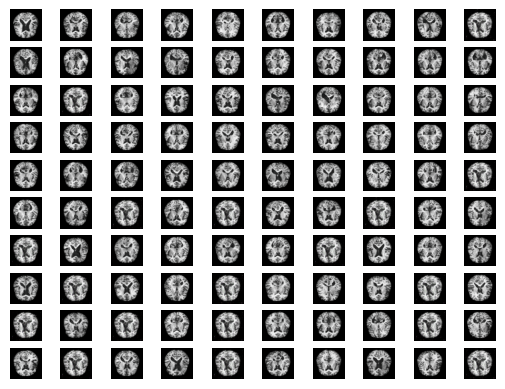

In [27]:
# generate multiple images

latent_points, labels = generate_latent_points(100, 100)
# specify labels - generate 10 sets of labels each gping from 0 to 9
#labels = asarray([x for _ in range(4) for x in range(4)])
# generate images
X  = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0
X = (X*255).astype(np.uint8)
# plot the result (10 sets of images, all images in a column should be of same class in the plot)
# Plot generated images 
def show_plot(examples, n):
	for i in range(n * n):
		plt.subplot(n, n, 1 + i)
		plt.axis('off')
		plt.imshow(examples[i, :, :, :])
	plt.show()
    
show_plot(X, 10)

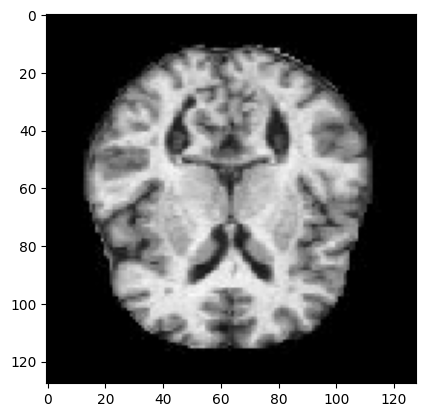

In [29]:
plt.imshow(trainX[46])

In [72]:
trainy[46]

array([2])

32/32 [==============================] - 2s 52ms/step


'E:\\alzeimher'

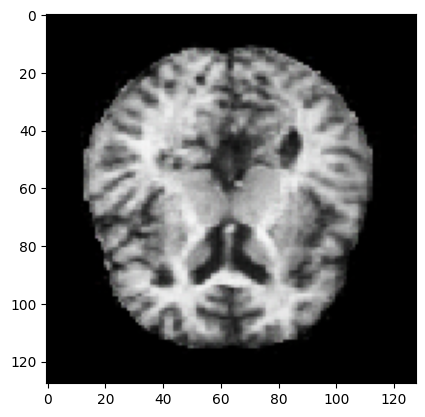

In [64]:
latent_points, _ = generate_latent_points(100, 1000)
#labels = np.array([2])
labels = 2*np.ones((1000,1))
X  = model.predict([latent_points, labels])
X = (X + 1) / 2.0
X = (X*255).astype(np.uint8)
image_path = os.getcwd()
image = Image.fromarray(X[0], 'RGB')
image = image.save(f"{image_path}\\generated_image\\image.png")
plt.imshow(X[0])
os.getcwd()

In [68]:
def alz(class_num, number_of_samples=1000):
    latent_points, _ = generate_latent_points(100, number_of_samples)
    label = class_num*np.ones((number_of_samples,1))
    X  = model.predict([latent_points, label])
    X = (X + 1) / 2.0
    X = (X*255).astype(np.uint8)
    image_path = os.getcwd()
    os.mkdir(f"{image_path}\\generated_image\\{class_num}")
    for i in range(number_of_samples):
        image = Image.fromarray(X[i], 'RGB')
        image = image.save(f"{image_path}\\generated_image\\{class_num}\\{i}.png")

In [70]:
for i in range(4):
    alz(i)

32/32 [==============================] - 2s 48ms/step
